### Group members and contributions

**Exam date:** 20-06-2025  
**Grade:** 30L

| Student            | ID       |
|--------------------|:--------:|
| Miriam Zara         | 2163328  |
| Giorgia Fasiolo     | 2159992  |
| Angela Bortolato    | 2156562  |
| Luca Volpi          | 2157843  |


In [2]:
# IMPORT THE NECESSARY LIBRARIES
import seaborn as sns
from mice_inspection_utils import * # Import all functions 
                                    # NOTICE: this is different from import mice_inspection_utils! In that case you'd have to use the module name as a prefic to access functions, classes or variables. E.g. mice_inspection_utils.some_function()
from glob import glob # Function that will later be used to find all files that match a pattern
from scipy.stats import gamma
import matplotlib.patches as mpatches
 
# This part avoids possible conflict due to the structure of mice_inspection_utils
# This part avoids possible conflict due to the structure of mice_inspection_utils
if not os.path.exists('Data/by_mouse_genus_aggregated'): 
    print('Missing data aggregated by mouse! Creating a new directory')
    os.makedirs('Data/by_mouse_genus_aggregated')

# GET THE NECESSARY DATA
imput_subj_paths = [f"Data/raw/total.full.rn.RA.total_OTU_table.mouse{i+1}.ovr0.0p.csv" for i in range(0, 8)]
output_subj_paths = [f"Data/by_mouse/mouse_{i+1}.csv" for i in range(0, 8)]
metadata_path = "Data/raw/OTU_table.csv"
mi = Mice_Inspection(ip = imput_subj_paths, op = output_subj_paths, mdp = metadata_path)

output_dir = "Outputs_PreliminaryAnalysis"
os.makedirs(output_dir, exist_ok = True)

# Population dynamics of bacteria in the gut microbiome: a data analysis

## Short description of the project

An important area of research focuses on uncovering the ecological interactions between species within the human or animal gut. This is highly relevant, as studies suggest that each individual harbors a unique, characteristic microbiota. Understanding the specific interactions between microbial species could enable the development of personalized therapies — for example, through microbiota transplantation — by identifying particular interaction mechanisms that help eliminate or at least reduce the abundance of pathogens.

In our project, following the article *"A macroecological description of alternative stable states reproduces intra- and inter-host variability of gut microbiome", Silvia Zaoli and Jacopo Grilli*, we analyze experimental data of mice gut microbiota assuming a simple stochastic logistic model. This model, specifically, assumes that each bacterial species evolves independently from the others, thus it can be used as a simple, essential null-model to investigate if inter-species interactions can be at all inferred from the data with the technologies available up to nowadays. 

The logistic model predicts that, after a transient, the species abundances will eventually settle down to a steady state, parametrized by two parametes: the carrying capacity, accounting for the global effect of the environment, and a parameter $\sigma$ quantifying the stochastic noise. We will follow the methods described in the article, which use a properly defined dissimilarity measure to assess stationarity, designed to overcome the scarsity of data samples.

This main task will require preliminary data processing and basic statistic analysis. 

## 1. **Preprocessing and sample composition analysis**

**Data description**: 

We have microbiota data from 8 mice, all born from the same parents and raised in the same cage. Fecal samples were collected from each mouse every few days (approximately every 4–7 days), and the bacterial composition was characterized using 16S rRNA sequencing.

This sequencing method introduces experimental uncertainty in assigning Operational Taxonomic Units (OTUs), as sequences are often incomplete and may not fully match reference databases. This is not a typical statistical error — it reflects a limitation of the method that is difficult to overcome.

**Criticalities:**
1. _Sampling limitations:_ We analyze only a small fraction of the total microbiota, which introduces statistical challenges. Rare species may go undetected in our samples. However, these rare species could still have significant ecological roles or influence interactions, even if they are not observed. In practice, our analysis implicitly assumes that causal effects are driven by abundant species and that rare species do not play major roles — an assumption that, although reasonable, may not always hold.

2. _Spurious correlations:_ Given the limited sampling, we may observe correlations between species that would not appear if we had data from the entire population. These apparent associations could mislead our interpretation of species interactions.

3. _Taxonomic resolution of 16s rRNA:_
16S rRNA sequencing is generally reliable for identifying bacteria at higher taxonomic levels (e.g. phylum or genus), but less accurate at resolving species-level classification. The variability in sequences, and even small mismatches, can lead to misclassification — for instance, a sequence might be assigned to species A when it actually corresponds to species B.

## Time series visualization

In pre-processing, we aggregaed reads for OTUs assigned to the same species. 

Ths is an example of time series of the Prevotella sp.Smarlab 121567 population from birth to death of the host. 

In [2]:
mi.plot_species_NEW(subjects = [1, 2], figsize = (10,4), save_fig = True, output_path = os.path.join(output_dir, "Prev_ts_for_slides.png"))
mi.plot_species_NEW(species = "Clostridium colinum",subjects = [1, 2], figsize = (10,4), save_fig = True, output_path = os.path.join(output_dir, "Clos_ts_for_slides.png"))

saved as Outputs_PreliminaryAnalysis/Prev_ts_for_slides.png
saved as Outputs_PreliminaryAnalysis/Clos_ts_for_slides.png


![Prevotella p.Smarlab 121567 time series](Outputs_PreliminaryAnalysis/ts_for_slides.png)

## Sample composition - analysis of the cross-subject sample composition variability at different taxonomic-unit levels

Biological organisms are classified in groups on the basis of similarity. Biologists refer to these groups as "taxonomic units" or taxa. Different taxa are also grouped together in a higher-level group ("taxon") based on commonly shared features, resulting in a nested hierarcical classification. The basic scheme of modern classification makes use of $8$ levels of classification, which are, from top to bottom: $\textit{Domain, Kindom, Phylum, Class, Order, Family, Genus, Species}$. 

The task is to assess the cross-subject variability of the sample composition at the various levels of the taxonomic classification. The output will be given in the form of stacked-bar plots.


When we look at composition across mice at various taxonomic levels (species, genus, family, order, class), we see the composition appears _homogeneous_ across individuals at higher levels like family, genus, etc... 

We have: 

Species: 1.260

Genus: 412

Family: 141

Order: 66

Class: 37

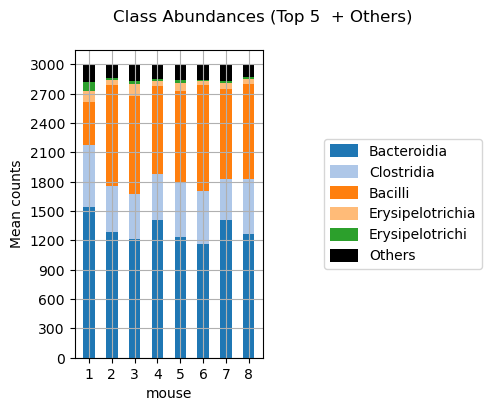

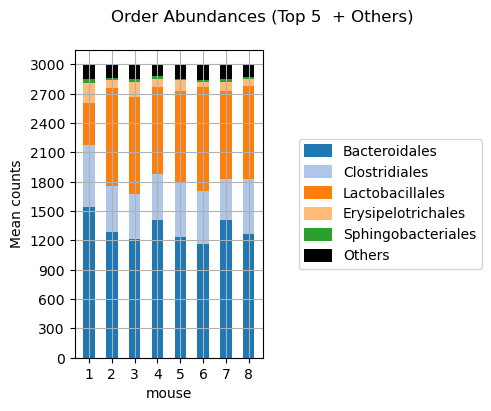

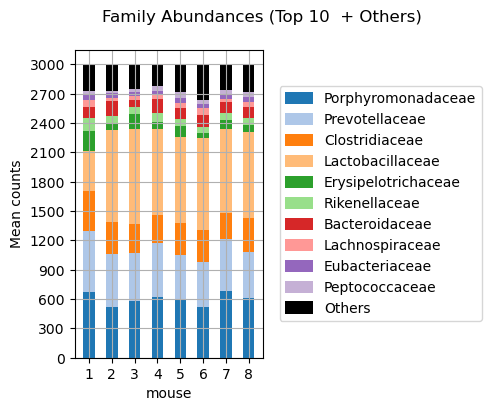

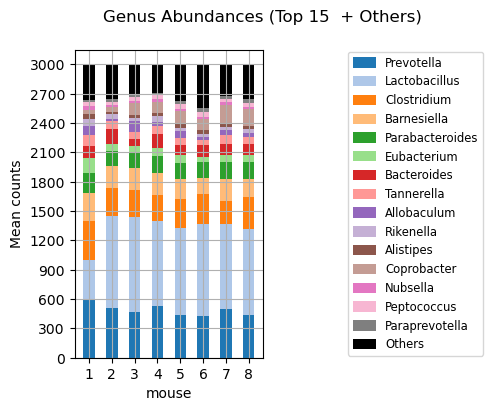

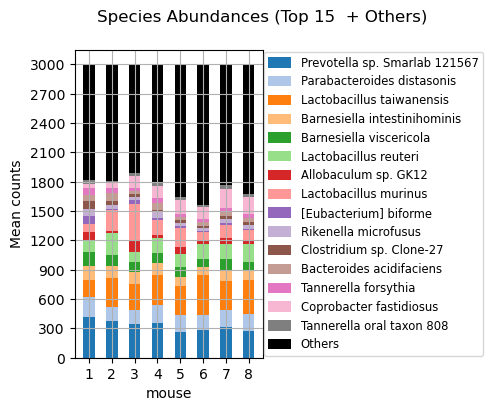

In [8]:
from functools import reduce
import matplotlib.gridspec as gridspec
import math
metadata_df = mi.metadata_df

def get_cathegory_df(cathegory = "Class", N = 40, grouped = True, which = "mean"):
    temp_df_list = []
    for mouse in range(0, 8):
        temp_df = mi.get_mice_df()[mouse].copy()
        temp_df["mean"] = temp_df.iloc[:, 1:].mean(axis=1)
        temp_df["median"] = temp_df.iloc[:, 1:].median(axis=1)
        temp_df = temp_df[["species", "mean", "median"]].copy()
        temp_df.rename(columns={"mean": f"mean_{mouse}", "median": f"median_{mouse}", "species": "Species"}, inplace=True)
        temp_df_list.append(temp_df)
    """
    Join dataframes. Keep all species. If a species is not sampled for a mouse, add NA
    """
    df = reduce(lambda left, right: pd.merge(left, right, on="Species", how="outer"), temp_df_list)
    """
    Add the information about the species taxonomic classification
    """
    if cathegory != "Species":
        info_df = mi.metadata_df[["Species", "Phylum", "Class", "Order", "Family", "Genus"]].drop_duplicates()
        info_df.rename(columns={"Species": "Species"}, inplace=True)
        df = pd.merge(df, info_df, on="Species", how="left")

    """
    Now filter by Cathegory, and group by mouse. Sum counts. 
    """

    if cathegory != "Species":
        if which == "both":
            mice_cols = [col for col in df.columns if (col.startswith("mean_") or col.startswith("median_"))]
        elif which == "mean":
            mice_cols = [col for col in df.columns if (col.startswith("mean_"))]
        else:
            mice_cols = [col for col in df.columns if (col.startswith("median_"))]
        cathegory_df = df.groupby(cathegory)[mice_cols].sum().reset_index()



    if cathegory == "Species":

        mice_cols = ["Species"]
        for col in df.columns:
            if (col.startswith("mean_")):
                mice_cols.append(col)
        cathegory_df = df[mice_cols]

    """
    Order in descending order (use mouse_0)
    """
    df_plot = cathegory_df.copy()
    df_plot.sort_values(by = "mean_0", ascending = False, inplace = True)
    df_plot.reset_index(drop=True, inplace=True)
    df_plot.head()
    """
    Group all but first N  in a unique row "Others"
    """
    if len(df_plot) > N:
        top_df = df_plot.iloc[:N].copy()
        others_df = df_plot.iloc[N:]
        others_sum = others_df.drop(columns=[cathegory]).sum()
        others_row = pd.DataFrame([["Others", *others_sum]], columns=df_plot.columns)
        df_plot_grouped = pd.concat([top_df, others_row], ignore_index=True)
    else:
        df_plot_grouped = df_plot.copy()
    """
    Normalize counts
    """
    #df_plot_grouped.iloc[:, 1:] /= mi.sample_size
    if grouped:
        return df_plot_grouped
    else:
        return df_plot



def plot_stacked(cathegory = "Genus", N = 10, figsize = (5, 4), save_fig= False, path = None, which = "mean"):
    df_plot_grouped = get_cathegory_df(cathegory = cathegory, N = N, grouped = True)
    # Settings
    colors = extended_tab20
    width = 0.5
    x_labels = [f"{j + 1}" for j in range(df_plot_grouped.shape[1] - 1)]  # exclude "Genus" column


    fig = plt.figure(figsize = figsize)
    gs = gridspec.GridSpec(nrows=1, ncols=6, figure=fig)
    ax1 = fig.add_subplot(gs[:, :3])
    ax2 = fig.add_subplot(gs[:, 3:])  

    bottom = np.zeros(len(x_labels))

    # Plot each category group
    for idx, row in df_plot_grouped.iterrows():
        label = row[cathegory]
        values = row.drop(labels=cathegory).to_numpy(dtype=float)
        color = "black" if label == "Others" else colors[idx % 20]
        ax1.bar(x_labels, values, width, label=label, bottom=bottom, color=color)
        bottom += values

    # Aesthetics
    #ax1.set_ylabel("Mean frequency")
    ax1.set_ylabel("Mean counts")
    ax1.set_xlabel("mouse")
    max_items_per_col = 40
    ncol = math.ceil(len(df_plot_grouped) / max_items_per_col)
    ax1.legend(#title=f"Most Abundant {cathegory}",
            bbox_to_anchor=(+2.2, 0.5),
            loc='right', ncol=ncol,
            handlelength=2, handleheight=1)#,
    if N > 10:
        ax1.legend(
            bbox_to_anchor=(+2.2, 0.5),
            loc='right', ncol=ncol,
            handlelength=2, handleheight=1,
            fontsize='small',
            title_fontsize='small')
    ax1.set_yticks(np.arange(0, 3001, 300))
    #ax1.set_yticks(np.arange(0, 1.1, 0.1))
    ax1.grid()
    ax2.axis("off")
    plt.suptitle(f"{cathegory} Abundances (Top {N}  + Others)")

    if (save_fig and path != None):
        plt.savefig(path, dpi = 300)
    return


plot_stacked(cathegory = "Class", figsize = (5,4), N = 5, save_fig = True, path = os.path.join(output_dir, "class_stacked.png"))
plot_stacked(cathegory = "Order", figsize = (5,4), N = 5, save_fig = True, path = os.path.join(output_dir, "order_stacked.png"))
plot_stacked(cathegory = "Family", figsize = (5,4), N = 10, save_fig = True, path = os.path.join(output_dir, "family_stacked.png"))
plot_stacked(cathegory = "Genus", figsize = (5,4), N = 15, save_fig = True, path = os.path.join(output_dir, "genus_stacked.png"))
plot_stacked(cathegory = "Species", figsize = (5,4), N = 15, save_fig = True, path = os.path.join(output_dir, "species_stacked.png"))

## Species RAD

In ecology (and in many other complex systems), RAD is a way of visualizing how species (or taxa) are distributed in terms of their abundance: you rank species from most abundant (rank 1) to least abuntant (rank N) and you plot their abundances (often on a log scale, since the expected behavior is a power law) against their rank. 

The resulting curve shows you how the ecosystem’s diversity is structured — whether most individuals belong to a few species or whether abundance is more evenly spread.

In many ecosystems — forests, oceans, gut microbiomes — RADs often follow a power-law-like behavior:
$$
Abundance \propto Rank^{-\alpha}
$$
where: 

- the highest-ranked species are extremely abundant; 
- as rank increases, abundance drops off steeply; 
- many species have very low abundance. 

Plotting the RAD in the log-log scale makes the power law fitting straightforward. Let's see if the RAD of our experimental data also follows a power-law like trend.

/Users/giorgiafasiolo/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


alpha= -1.0110523319279088
saved as Outputs_PreliminaryAnalysis/ts_for_slides_rare.png


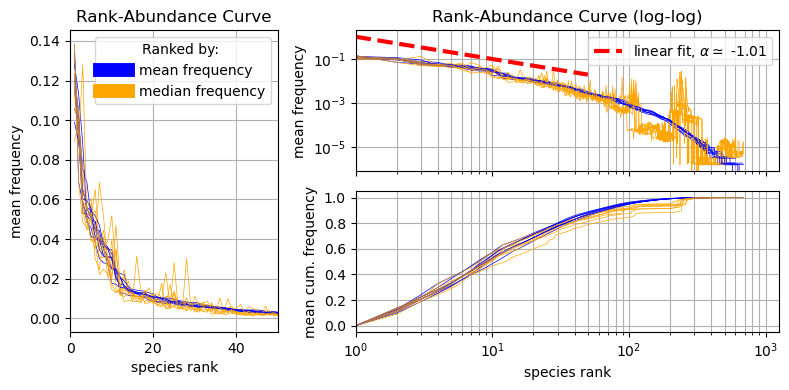

In [9]:
out_path = os.path.join(output_dir, "RAD.png")


df_mice_by_mean  = mi.get_mice_df(sort_by = "mean")
df_mice_by_median  = mi.get_mice_df(sort_by = "median")

rad_by_mean = []
rad_by_median = []

for n in range(mi.subjects):
    df = df_mice_by_mean[n]
    y_mean = df.iloc[:, 1:].mean(axis = 1) / mi.sample_size # frequencies
    rad_by_mean.append(y_mean)

    df = df_mice_by_median[n]
    y_median = df.iloc[:, 1:].mean(axis = 1) / mi.sample_size # frequencies
    rad_by_median.append(y_median)

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 4))

gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1, 1], width_ratios=[3, 3, 2])
# Example: ax1 takes the left two-thirds of the top row
ax1 = fig.add_subplot(gs[0, 1:3])

# Example: ax2 takes the right one-third of the top row
ax2 = fig.add_subplot(gs[1, 1:3])

ax3 = fig.add_subplot(gs[:, 0])

ax = [ax1, ax2, ax3]



l = 0.5 # linewidth
color_mean = "blue"
color_median = "orange"

for n in range(mi.subjects):
    # RAD by mean
    y = rad_by_mean[n]
    x_max = len(y)
    x = np.arange(1, x_max + 1)
    y_cum = [np.sum(y[0:(rank - 1)]) for rank in x] # cum frequencies
    if n == 0:
        ax[0].plot(x, y, color = color_mean, linewidth = l)#, label = f'mean frequency')
        ax[2].plot(x, y, color = color_mean, linewidth = l, label = f'mean frequency')
        ax[1].plot(x, y_cum, color = color_mean,linewidth = l)#, label = f'mean frequency')
    else:
        # no label
        ax[0].plot(x, y, color = color_mean, linewidth = l)
        ax[2].plot(x, y, color = color_mean, linewidth = l)
        ax[1].plot(x, y_cum, color = color_mean, linewidth = l)

    # RAD by median
    y = rad_by_median[n]
    x_max = len(y)
    x = np.arange(1, x_max + 1)
    y_cum = [np.sum(y[0:(rank - 1)]) for rank in x] # cum frequencies
    if n == 0:
        ax[0].plot(x, y, color = color_median, linewidth = l)#, label = f'median frequency')
        ax[2].plot(x, y, color = color_median, linewidth = l, label = f'median frequency')
        ax[1].plot(x, y_cum, color = color_median, linewidth = l)#, label = f'median frequency')
    else:
        # no label
        ax[0].plot(x, y, linewidth = l, color = color_median)
        ax[2].plot(x, y, linewidth = l, color = color_median)
        ax[1].plot(x, y_cum, linewidth = l, color = color_median)

# Power law fit
from scipy.stats import linregress
y = rad_by_mean[0]
x_max = len(y)
x = np.arange(1, x_max + 1)
log_x = np.log(x)[0:50]
log_y = np.log(y)[0:50]
result = linregress(x = log_x, y = log_y)
print("alpha=",result.slope)
y_fit = np.exp(np.log(x)[0:50] * result.slope)
ax[0].plot(x[0:50], y_fit, color = "red", linestyle = "dashed", linewidth = 3, label = fr"linear fit, $\alpha \simeq$ {result.slope:.2f}")
ax[0].legend()


# Global plot aestethics
ax[0].set_xlim(1, 1260)
ax[0].tick_params(labelbottom=False)
ax[1].set_xlim(1, 1260)
ax[0].set_title("Rank-Abundance Curve (log-log)", fontsize = 'large')
ax[0].set_xlabel("")
ax[0].set_ylabel("mean frequency")
ax[0].grid(which= "both", axis = "x")
ax[0].grid(which= "major", axis = "y")
legend = ax[2].legend(title = "Ranked by: ")
for line in legend.get_lines():
    line.set_linewidth(10)

ax[2].set_xlim(0, 50)
ax[2].set_xticks(np.arange(0, 50, 20))
ax[2].set_xlabel("species rank")
ax[2].set_title("Rank-Abundance Curve", fontsize = 'large')
ax[2].set_ylabel("mean frequency")
ax[2].grid(which= "both", axis = "x")
ax[2].grid(which= "major", axis = "y")


#ax[1].set_title("Cum. Rank-Abundance Curve", fontsize = 'large')
ax[1].set_xlabel("species rank")
ax[1].set_ylabel("mean cum. frequency")
ax[1].set_yticks(np.arange(0, 1.1, 0.2))
ax[1].grid(which= "both", axis = "x")
ax[1].grid(which= "major", axis = "y")


ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_xscale("log")


plt.subplots_adjust(wspace = 0.4)
plt.tight_layout()
plt.savefig(out_path, dpi = 600)


rare_species = ['Vibrio cholerae', '[Eubacterium] biforme', 'Streptococcus sp. B1']
mi.plot_species_MEAN_ONLY(species_list = rare_species, size = (4,2.5), save_fig = True, output_path = os.path.join(output_dir, "ts_for_slides_rare.png"))

Indeed, it does. However, we can see a substantial deviation from the linear fit (blue curve is pointing downwards) towards the right end.

This can be explained by looking at the median abundance vs rank (yellow curve). When the time series is stationary, we dont expect to see any significative difference between the mean abundance and the median abundance, so the two curves should overlap. However, in the right end of the rank spectrum (i.e., for the rare species) we see that the mean and the median can be significatively different - a first hint of non- stationarity.

This is confirmed by looking directly at the time series of these species.

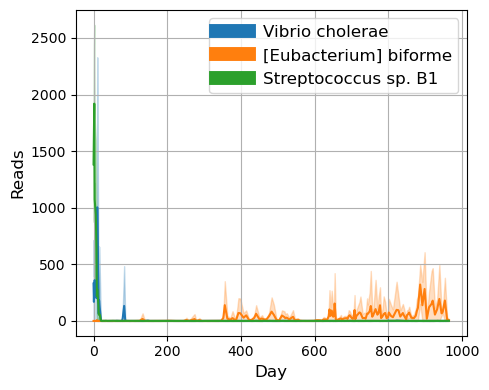

In [10]:
df  = mi.get_mice_df(sort_by = "mean")[0]
#print(df["species"].iloc[150:160])
some_rare_species = ['Vibrio cholerae', '[Eubacterium] biforme', 'Streptococcus sp. B1']
mi.plot_species_MEAN_ONLY(species_list = some_rare_species, size = (5, 4), save_fig = False)

## (% ID): Reliability of OTU to Species assignation

As introduced earlier, a key question is: how reliable are taxonomic assignments at the species level? Should we trust species-level data, or is genus-level a safer resolution?

Our raw data consists of OTU (Operational Taxonomic Unit) reads. In this context, an OTU represents a unique 16S rRNA sequence identified in the fecal sample. Instead, the number of *reads* is the number of times a given OTU is sampled from the PCR-amplified genetic material. Just for the sake of clarity, lets make an example. Consider the following sample of ficticious RNA strands:


ADTFT

SEHFIT

ADTFT

ADTFT

EBCURL

SEHFIT

The classification as OTUs would be:

| OTU | Number of Reads | Sequence |
|-----|------------------|----------|
| 001 | 3                | ADTFT    |
| 002 | 2                | SEHFIT   |
| 003 | 1                | EBCURL   |


From a biological standpoint, each species is characterized by a distinct 16S rRNA sequence, with most inter-species variability concentrated within one or more of the nine hypervariable regions of the gene. However, sequences obtained from experimental samples can be incomplete, contain mismatches, or have missing bases. This results in more OTUs than actual species. 

In [11]:
df = pd.read_csv("Data/raw/OTU_table.csv") # load the raw metadata
df.head()

Unnamed: 0           query  \
0  OTU00001 Prevotella sp. Smarlab 121567 (79.62%)  total_OTU00001   
1        OTU00002 Lactobacillus taiwanensis (100%)  total_OTU00002   
2     OTU00003 Parabacteroides distasonis (82.35%)  total_OTU00003   
3       OTU00004 Lactobacillus intestinalis (100%)  total_OTU00004   
4            OTU00005 Lactobacillus murinus (100%)  total_OTU00005   

   total_reads SuperKingdom         Phylum        Class            Order  \
0       551353     Bacteria  Bacteroidetes  Bacteroidia    Bacteroidales   
1       506044     Bacteria     Firmicutes      Bacilli  Lactobacillales   
2       266284     Bacteria  Bacteroidetes  Bacteroidia    Bacteroidales   
3       210843     Bacteria     Firmicutes      Bacilli  Lactobacillales   
4       288032     Bacteria     Firmicutes      Bacilli  Lactobacillales   

               Family            Genus                        Species  \
0      Prevotellaceae       Prevotella  Prevotella sp. Smarlab 121567   
1    Lactobacillaceae    Lactobacillus      Lactobacillus taiwanensis   
2  Porphyromonadaceae  Parabacteroides     Parabacteroides distasonis   
3    Lactobacillaceae    Lactobacillus     Lactobacillus intestinalis   
4    Lactobacillaceae    Lactobacillus          Lactobacillus murinus   

    Database ID    % id  alignment length  mismatches  gap openings  e-value  \
0    S000019396   79.62               317          64             3      0.0   
1  T-S001016089  100.00               339           0             0      0.0   
2  NC-009615-02   82.35               322          54            16      0.0   
3    S000995980  100.00               332           0             0      0.0   
4    S000870722  100.00               332           0             0      0.0   

   bit score  coverage                                           sequence  
0      268.0       100  GATGAACGCTAGCGGCAGGCTTAACACATGCAAGTCGAGGGGCAGC...  
1      472.2       100  GACGAACGCTGGCGGCGTGCCTAATACATGCAAGTCGAGCGAGCTT...  
2      260.8       100  GATGAACGCTAGCGGCAGGCTTAACACATGCAAGTCGAACGGCAGC...  
3      462.5       100  GACGAACGCTGGCGGCGTGCCTAATACATGCAAGTCGAGCGAGCTG...  
4      462.5       100  GATGAACGCTGGCGGCGTGCCTAATACATGCAAGTCGAACGAAACT...

21768
21768
333.3231348768835 49.256916280035355


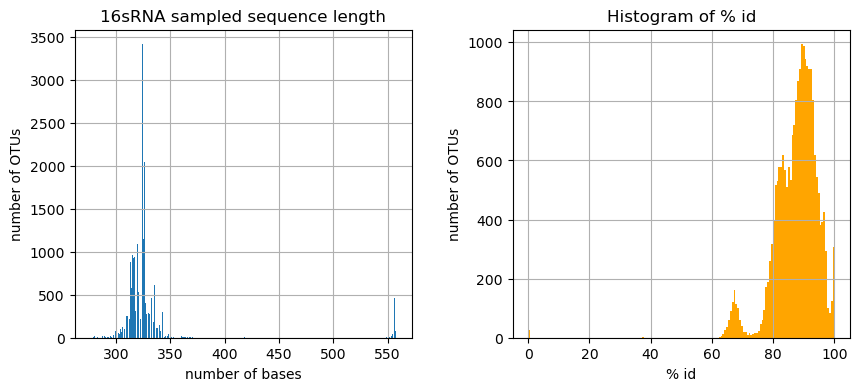

In [12]:
df = pd.read_csv("Data/raw/OTU_table.csv") # load the raw metadata
sequences = df["sequence"].to_numpy() # extract all the sampled rna sequences == OTUs
alignments = df["alignment length"].to_numpy() # extract all the sampled rna sequences == OTUs

print(len(np.unique(sequences))) # number of unique sequences
print(len(sequences)) # number of OTUs
# They are the same number ->
# one to one correspondence between sequence and OTU

# Let's also compute the length of these rna sequences

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
axs = axs.flatten()

ax = axs[0]
lengths = np.array([len(string) for string in sequences])
avg_length = np.mean(lengths)
std_length = np.std(lengths)
print(avg_length, std_length)
ax.hist(lengths, bins='auto') 
ax.grid()
ax.set_title("16sRNA sampled sequence length")
ax.set_xlabel("number of bases")
ax.set_ylabel("number of OTUs")

ax = axs[1]
id = df["% id"].to_numpy()
ax.hist(id, bins='auto', color = "orange") 
ax.set_title("Histogram of % id")
ax.set_xlabel("% id")
ax.grid()
ax.set_ylabel("number of OTUs")

plt.subplots_adjust(wspace = 0.3)
plt.show()

To assign taxonomy, each OTU sequence is aligned against a reference database of known 16S sequences. The percent identity (%ID) quantifies the similarity between the OTU and its best match in the database, providing an estimate of the reliability of the taxonomic assignment.

Let us look now at the distribution of the %ID score. What is the uncertainty of our data?

on the x-axis: %ID (percent identity between OTU sequence and the closest known species)

on the y-axis: Fraction of OTUs (or fraction of reads) that have at least that %ID.

37 66 141 412 1260


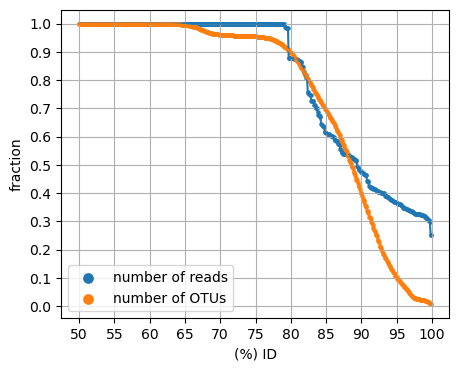

In [13]:
metadata_df = pd.read_csv(metadata_path)

# Extract these values
total_species = len(np.unique(metadata_df['Species']))
total_genus = len(np.unique(metadata_df['Genus']))
total_family = len(np.unique(metadata_df['Family']))
total_order = len(np.unique(metadata_df['Order']))
total_class = len(np.unique(metadata_df['Class']))

print(total_class, total_order, total_family, total_genus, total_species)

# Compute the fraction of reads/OTU that has at least a given %ID
df = metadata_df[["query", "total_reads", "% id"]]
total_ = df["total_reads"].sum()
total_otus = len(df)

thresholds = np.arange(50, 100, 0.1)
reads_fraction = np.zeros(len(thresholds))
otus_fraction = np.zeros(len(thresholds))

for i, t in enumerate(thresholds):
    reads_fraction[i] = df[df["% id"] > t]["total_reads"].sum() / total_
    otus_fraction[i] = len(df[df["% id"] > t]["total_reads"]) / total_otus

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4))
ax.scatter(thresholds, reads_fraction, s = 5, label = "number of reads")
ax.plot(thresholds, reads_fraction)
ax.grid(which = "both")
ax.set_xlabel("(%) ID")
ax.set_ylabel("fraction")
ax.set_xticks(np.arange(50, 101, 5))
ax.set_yticks(np.arange(0, 1.1, 0.1))
#ax.set_xticklabels(np.arange(0, 1.1, 0.1))

ax.scatter(thresholds, otus_fraction, s = 5, label = "number of OTUs")
ax.plot(thresholds, otus_fraction)
ax.legend(markerscale = 3)

output_path = os.path.join(output_dir, "assignment_confidence.png")
plt.savefig(output_path, dpi = 600)

The plot shows that only a small fraction of OTUs achieve a high %ID match to reference sequences. As the %ID threshold is lowered, more reads are included but we have increasing uncertainty about the true species identity.

Excluding all OTUs below a stringent identity threshold (e.g., >95%) is NOT a viable option, as would result in discarding the majority of the data!

As a trade off, we could aggregate OTU counts at a higher taxonomic rank — specifically, at the Genus level. Although this reduces the taxonomic resolution of the microbiota profile, it improves reliability: genus-level assignments are more robust because 16S rRNA sequences are more conserved at this level and are thus less affected by sequencing errors, alignment mismatches, or intra-species variation.

## Genus aggregated data

Given the low confidence in species-level annotations, it could be reasonable to aggregate OTU data at the Genus level.

This choice relies on the biological assumption that species within the same genus should exhibit similar ecological behavior. In particular, we expect their temporal dynamics to be correlated. To test this assumption empirically, we take a simple approach: we compute pairwise correlations between all species’ time series and compare the intra-genus correlations (between species in the same genus) to inter-genus correlations (between species in different genera). A significantly higher intra-genus correlation would support our aggregation strategy.

Before we move forward, let us make two important comments:

1. **Aggregating at the genus level may also benefit downstream tasks such as interaction network inference.**

Inferring species interactions from time series typically requires a large number of samples, which is often not available. A common workaround is to reduce the number of nodes by selecting only the top-N most abundant species (e.g., top 100). However, this strategy disproportionately includes a few dominant genera (e.g., Prevotella, Lactobacillus), leading to networks biased toward intra-genus interactions.

These interactions are often negative (competitive), since closely related species tend to compete for similar resources. While of course valid, such interactions are less informative for understanding broader ecological dynamics.

By aggregating at the genus level, we reduce the number of nodes while preserving broader taxonomic diversity, which helps reveal a more meaningful and interpretable interaction structure. This is particularly useful when imposing thresholds on network size.

2. **Filtering low-abundance species**

We do not include all species from a genus in the analysis. Instead, we retain only those above a mean abundance threshold. Based on the species Rank-Abundance Distribution (RAD), we observe that $\gt 90$% of total reads originate from species with frequency $\geq 10^{-3}$ (i.e., mean counts $\geq 3$). Species below this threshold are typically dominated by zero values across time  and are likely to reflect noise rather than signal. We exclude them to ensure that computed correlations are not spurious.

In [3]:
df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")
df = df.drop(columns=["Unnamed: 0", "day"])
df.head(30)

Prevotella sp. Smarlab 121567  Parabacteroides distasonis  \
0                             0.0                         0.0   
1                             NaN                         NaN   
2                             NaN                         NaN   
3                             NaN                         NaN   
4                             NaN                         NaN   
5                             NaN                         NaN   
6                             NaN                         NaN   
7                             0.0                         0.0   
8                             0.0                         0.0   
9                             2.0                         2.0   
10                            NaN                         NaN   
11                            NaN                         NaN   
12                            NaN                         NaN   
13                            NaN                         NaN   
14                           10.0                        41.0   
15                            NaN                         NaN   
16                           18.0                       145.0   
17                            NaN                         NaN   
18                            NaN                         NaN   
19                           21.0                        43.0   
20                           33.0                        58.0   
21                            3.0                        54.0   
22                            5.0                        40.0   
23                           39.0                        48.0   
24                            NaN                         NaN   
25                            NaN                         NaN   
26                           91.0                       206.0   
27                           79.0                       177.0   
28                          108.0                       120.0   
29                          250.0                       138.0   

    Lactobacillus taiwanensis  Barnesiella intestinihominis  \
0                         0.0                           0.0   
1                         NaN                           NaN   
2                         NaN                           NaN   
3                         NaN                           NaN   
4                         NaN                           NaN   
5                         NaN                           NaN   
6                         NaN                           NaN   
7                       422.0                           0.0   
8                       309.0                           0.0   
9                         0.0                           1.0   
10                        NaN                           NaN   
11                        NaN                           NaN   
12                        NaN                           NaN   
13                        NaN                           NaN   
14                       48.0                          19.0   
15                        NaN                           NaN   
16                       15.0                          58.0   
17                        NaN                           NaN   
18                        NaN                           NaN   
19                      999.0                          28.0   
20                      156.0                          52.0   
21                     1096.0                          14.0   
22                      712.0                          44.0   
23                      134.0                           9.0   
24                        NaN                           NaN   
25                        NaN                           NaN   
26                      175.0                         140.0   
27                       56.0                         223.0   
28                      339.0                          88.0   
29                      356.0                         250.0   

    Barnesiella viscericola  Lacto

['Prevotella sp. Smarlab 121567', 'Prevotella loescheii', 'Prevotella shahii', 'Prevotella sp. oral taxon 317', 'Candidatus Prevotella conceptionensis', 'Prevotella genomosp. C1', 'Prevotella oulorum', 'Prevotella oris']
['Prevotella sp. Smarlab 121567', 'Prevotella loescheii', 'Prevotella shahii', 'Prevotella sp. oral taxon 317', 'Candidatus Prevotella conceptionensis', 'Prevotella genomosp. C1', 'Prevotella oulorum', 'Prevotella oris']
Mean correlation for genus Prevotella=  0.29200574330144935
['Lactobacillus taiwanensis', 'Lactobacillus reuteri', 'Lactobacillus murinus']
['Lactobacillus taiwanensis', 'Lactobacillus reuteri', 'Lactobacillus murinus']
Mean correlation for genus Lactobacillus=  0.2522362266897537


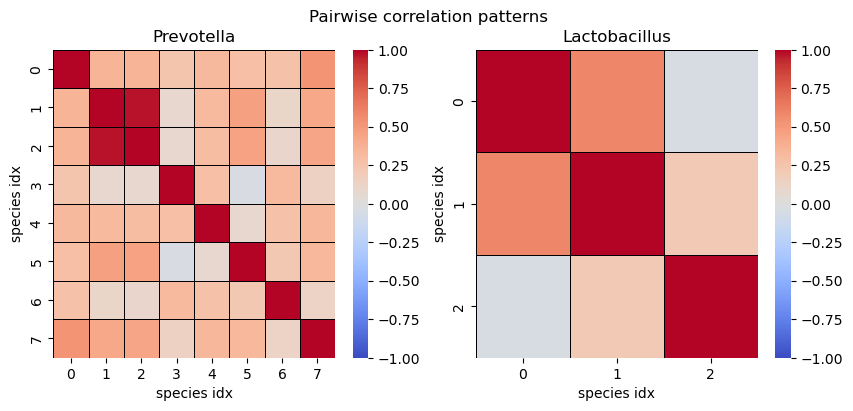

In [5]:
# Get the metadata
metadata_df = mi.metadata_df
# Extract columns Genus and Species and drop duplicate rows (in case multiple rows refer to the same genus-species combo)
unique_combos = metadata_df[['Genus', 'Species']].drop_duplicates()
# Dictionary where key = species, value = genus: lookup table: for each species you can find its genus
mapping = dict(zip(unique_combos['Species'], unique_combos['Genus']))
# List unique genus names present in mapping
# np.unique(mapping.values())

# Load transposed mouse data: eacg column is a species, each row a time point
#df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")

def species_list(genus, df, filter = True, threshold = 3):
    """
    Selects species in the mouse dataframe (df) that belong to the chosen genus.
    Optionally, it also filters the list, returning only those species with a median abundance over a certain threshold.
    """
    species = df.columns[0:]
    if filter and (threshold is not None):
        bool_mask = [(mapping[f'{species_}']== f"{genus}" and (df[f'{species_}'].median() > threshold) ) for species_ in species]
    else: 
         bool_mask = [(mapping[f'{species_}']== f"{genus}") for species_ in species]
    filtered_species = species[bool_mask].to_list()
    num_species = len(filtered_species)
    print(filtered_species)
    return filtered_species, num_species

def genus_corr(genus_a, genus_b):
    """
    Computes the average pairwise correlation of time series of species belonging to same genus.
    """
    filtered_species_a, num_species_a = species_list(genus_a, df)
    filtered_species_b, num_species_b = species_list(genus_b, df)
    if num_species_a < 1 or num_species_b <1:
        estimated_pearson = None
        return
    
    # Store the abundance time series for each selected species
    series_a = {s: df[s].values for s in filtered_species_a}
    series_b = {s: df[s].values for s in filtered_species_b}

    # Initialize matrices for covariance and Pearson correlation
    estimated_covariance = np.full((num_species_a, num_species_b), np.nan)
    estimated_pearson = np.full((num_species_a, num_species_b), np.nan)

    for i, s_a in enumerate(filtered_species_a):
        a = series_a[s_a]
        for j, s_b in enumerate(filtered_species_b):
            b = series_b[s_b]

            mask = ~np.isnan(a) & ~np.isnan(b)
            if np.sum(mask) > 1:
                a_masked = a[mask]
                b_masked = b[mask]

                cov = np.cov(a_masked, b_masked)[0, 1]
                denom = np.sqrt(np.var(a_masked) * np.var(b_masked))

                estimated_covariance[i, j] = cov
                if denom > 0:
                    estimated_pearson[i, j] = cov / denom

    mean_val = np.nan
    if (estimated_pearson is not None) and (genus_a == genus_b):
        """
        Compute the mean of off-diagonal entries only (cross-correlations)
        """
        diag_mask = ~np.eye(estimated_pearson.shape[0], estimated_pearson.shape[1], dtype=bool)
        mean_val = np.nanmean(estimated_pearson[diag_mask])
        
    elif (estimated_pearson is not None) and (genus_a != genus_b):
        """
        Compute the mean of all entries
        """
        mean_val = np.nanmean(estimated_pearson)
    return estimated_pearson, mean_val

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ax = axs.flatten()

genus = "Prevotella"
estimated_pearson, mean_val = genus_corr(genus, genus)
print(f"Mean correlation for genus {genus}= ", mean_val)
sns.heatmap(estimated_pearson, ax = ax[0], annot=False, cmap='coolwarm', linecolor = "black", vmin = -1, vmax = +1, linewidths=0.5, cbar=True)
ax[0].set_title(genus)
ax[0].set_xlabel("species idx")
ax[0].set_ylabel("species idx")

genus = "Lactobacillus"
estimated_pearson, mean_val = genus_corr(genus, genus)
print(f"Mean correlation for genus {genus}= ", mean_val)
sns.heatmap(estimated_pearson, ax = ax[1], annot=False, cmap='coolwarm', linecolor = "black", vmin = -1, vmax = +1, linewidths=0.5, cbar=True)
ax[1].set_title(genus)
ax[1].set_xlabel("species idx")
ax[1].set_ylabel("species idx")

plt.suptitle("Pairwise correlation patterns")

plt.savefig(os.path.join(output_dir, "intra_genus_correlation_patterns.png"), dpi = 300)

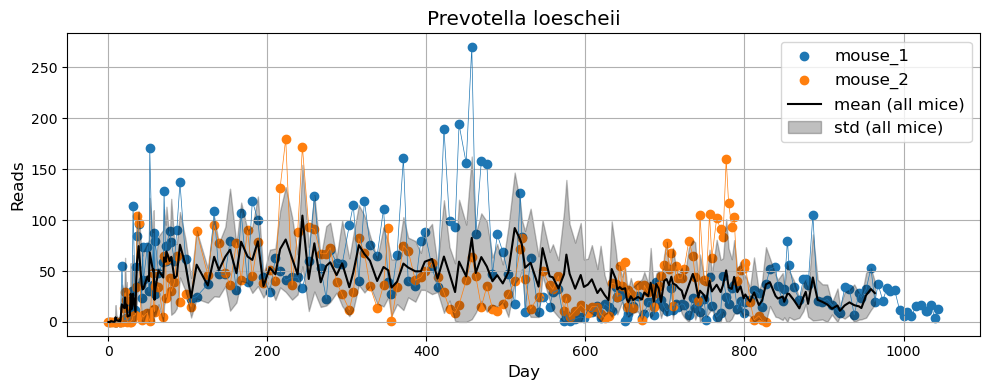

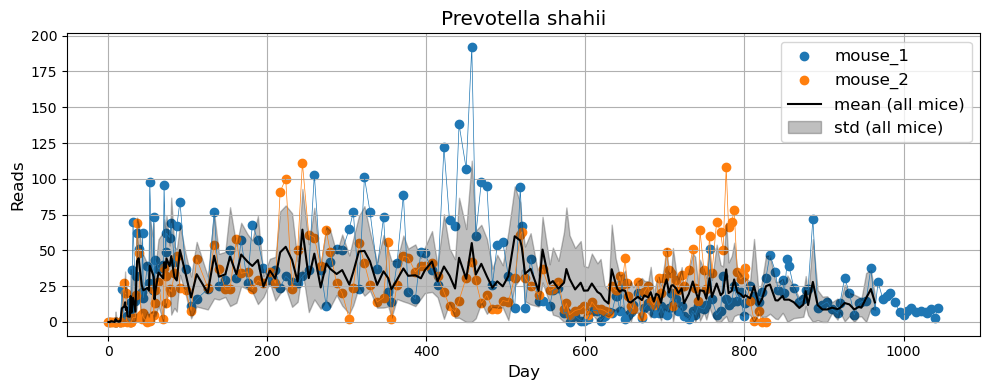

In [7]:
mi.plot_species_NEW(species = 'Prevotella loescheii', subjects = [1, 2], figsize = (10,4), save_fig = False)
mi.plot_species_NEW(species = 'Prevotella shahii', subjects = [1, 2], figsize = (10,4), save_fig = False)

In [7]:
# Extract unique genera names

genera = np.unique(list(mapping.values()))

# Filter out genera with less than  1 species
bool_mask =  np.full(len(genera), False, dtype=bool)
for i,genus in enumerate(genera):
    _, num_species = species_list(genus, df)
    if num_species > 1:
        bool_mask[i] = True
populated_genera = genera[bool_mask]
print("Populated genera:", populated_genera)

genera = populated_genera

# Mean correlation matrix
# Will store the mean correlation between genus i and genus j
mean_correlation = np.zeros(shape = (len(genera), len(genera)))


for i, genus_a in enumerate(genera):
    for j in range(i + 1, len(genera)):
        genus_b = genera[j]
        corr, mean = genus_corr(genus_a, genus_b)
        mean_correlation[i, j] = mean
        mean_correlation[j, i] = mean

for i, genus in enumerate(genera):
    corr, mean = genus_corr(genus, genus)
    mean_correlation[i, i] = mean

Populated genera: ['Alistipes' 'Bacteroides' 'Barnesiella' 'Clostridium' 'Eubacterium'
 'Lactobacillus' 'Oscillibacter' 'Prevotella' 'Tannerella']


Mean inter genus:  0.0095454095948213
Mean intra genus:  0.3579563983251281


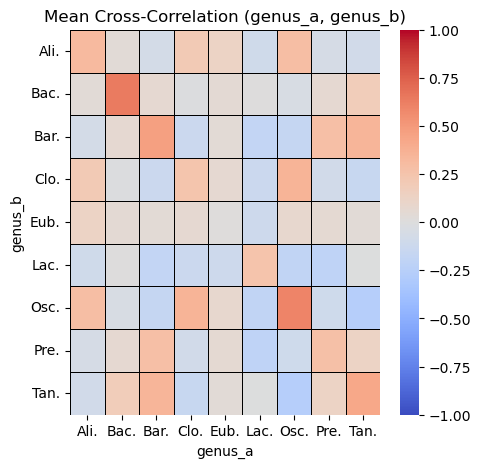

In [6]:
# For each genera create a shorter label
shortened = [word[:3]+ "." for word in genera]

# Visualize the heatmap of mean cross-correlations
plt.figure(figsize=(5, 5))
sns.heatmap(mean_correlation, xticklabels = shortened, yticklabels = shortened, annot=False, cmap='coolwarm', vmin = -1, vmax = +1, linecolor = "black", linewidths=0.5, cbar=True)
plt.xticks(rotation=0)   # Rotate x-axis labels
plt.yticks(rotation=0)    # Rotate y-axis labels
plt.xlabel("genus_a")
plt.ylabel("genus_b")
plt.title("Mean Cross-Correlation (genus_a, genus_b)")
plt.savefig(os.path.join(output_dir, "genera_cross_corr_pattern.png"), dpi = 300)

# Compute and print means inter/intra genus
mean_inter_genus = np.nanmean(mean_correlation[~np.eye(mean_correlation.shape[0], dtype=bool)])
mean_intra_genus = np.nanmean(np.diag(mean_correlation))

print("Mean inter genus: ", mean_inter_genus)
print("Mean intra genus: ", mean_intra_genus)

## 2. **Theoretical model**



#### Deterministic Logistic Model

The deterministic logistic model represents the growth of a population, or in this case the abundance $\lambda$ of a microbial species, constrained by the enviroment. 
The equation for DLM is: $$\dot{\lambda} = \frac{1}{\tau}\lambda \left(1-\frac{\lambda}{K}\right)  $$

This model has two parameters:
* K: the carrying capacity, it is the maximum population size that an enviroment can sustain, given the available resources.

* $\tau$: relaxation time, it is related to the growth rate of the population and determines the time scale of relaxation to stationarity.

1. When $\lambda$ is small, growth is nearly exponential.
2. When $\lambda$ gets close to K, growth slows.
3. When $\lambda=K$, growth stops as $\dot{\lambda}=0$ 



#### Stochastic logistic model

The stochastic version of the model introduces some randomness due to enviromental fluctuatons by adding a noise term, which better reflects real-world variability:
$$\dot{\lambda} = \frac{1}{\tau}\lambda \left(1-\frac{\lambda}{K}\right)  + \lambda \sqrt{\frac{\sigma}{\tau}}\xi(t) $$
where $\xi(t)$ is the Gaussian white noise.

This model has three parameters: 
* K, $\tau$ previously described.
* $\sigma$: it measures the intensity of the enviromental noise. 

The SLM does not include interaction among species and therefore cannot reproduce patterns of interspecies correlation. However, it correctly reproduces several patterns of the dynamics of a single species, including fluctuations and possible extinction events in small populations.

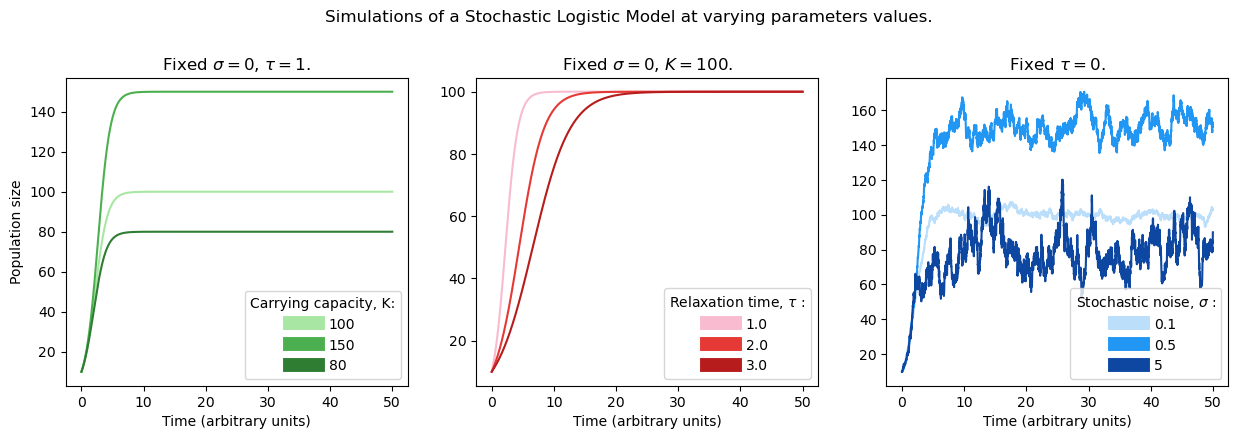

In [21]:
# DEFINE THE (DETERMINISTIC) LOGISTIC MODEL FUNCTION
def LM(ab0, K, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that species of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]
        ab_vals[t] = ab + (ab/tau)*(1 - (ab / K)) * dt[t-1]
        # Prevent numerical issues
        ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
    return ab_vals


# Define the function to simulate a stochastic logistic model
def simulate_SLM(ab0, K, sigma, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that species of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]
        ab_vals[t] = ab + ( (ab/tau)*(1 - (ab / K)) +  ab * np.sqrt(sigma/tau) * np.random.normal() ) * dt[t-1]
        # Prevent numerical issues
        #ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
        ab_vals[t] = max(0, ab_vals[t])
    return ab_vals



param_sets = [
    # Different carrying capacity
    {"ab0": 10, "K": 100, "sigma": 0.1, "tau": 1.0},
    {"ab0": 10, "K": 150, "sigma": 0.05, "tau": 1.0},
    {"ab0": 10, "K": 80, "sigma": 0.2, "tau": 1.0},
    # Different relaxation time
    {"ab0": 10, "K": 100, "sigma": 0.1, "tau": 1.0},
    {"ab0": 10, "K": 100, "sigma": 0.1, "tau": 2.0},
    {"ab0": 10, "K": 100, "sigma": 0.1, "tau": 3.0}
]

steps = 5000
results = []

for i, params in enumerate(param_sets):
    dt = np.asarray([0.01]*steps)
    ab_vals = LM(params["ab0"], params["K"], params["tau"], steps, dt)
    results.append({
        "run": i,
        "params": params,
        "ab_vals": ab_vals
    })


# Plot results

green_palette = ['#A8E6A3', '#4CAF50', '#2E7D32']
red_palette   = ['#F8BBD0', '#E53935', '#B71C1C']
blue_palette  = ['#BBDEFB', '#2196F3', '#0D47A1']


fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))
axs = axs.flatten()

time_vals = np.linspace(0, steps * dt[0], steps + 1)
ax = axs[0]
for i in range(0,3):
    ax.plot(time_vals, results[i]["ab_vals"], label=results[i]["params"]["K"], color = green_palette[i])
ax.set_xlabel("Time (arbitrary units)")
ax.set_title(r"Fixed $\sigma = 0$, $\tau = 1$.")
ax.set_ylabel("Population size")
legend = ax.legend(title = "Carrying capacity, K:")
for line in legend.get_lines():
    line.set_linewidth(10)



ax = axs[1]
for i in range(3,6):
    ax.plot(time_vals, results[i]["ab_vals"], label=results[i]["params"]["tau"], color = red_palette[i-3])
ax.set_title(r"Fixed $\sigma = 0$, $K = 100$.")
ax.set_xlabel("Time (arbitrary units)")
legend = ax.legend(title = r"Relaxation time, $\tau$ :")
for line in legend.get_lines():
    line.set_linewidth(10)


param_sets = [
    # Different sigmas and Ks (to help visualization)
    {"ab0": 10, "K": 100, "sigma": 0.1, "tau": 1.0},
    {"ab0": 10, "K": 150, "sigma": 0.5, "tau": 1.0},
    {"ab0": 10, "K": 80, "sigma": 5, "tau": 1.0},
]

results = []

for i, params in enumerate(param_sets):
    steps = 5000  # Number of steps
    dt = np.asarray([0.01]*steps)  # Time step
    ab_vals = simulate_SLM(ab0 = params["ab0"],  K =params["K"], sigma = params["sigma"],tau = params["tau"],steps = steps, dt = dt)
    results.append({
        "run": i,
        "params": params,
        "ab_vals": ab_vals
    })



ax = axs[2]
for i in range(0, 3):
    ax.plot(time_vals, results[i]["ab_vals"], label=results[i]["params"]["sigma"], color = blue_palette[i])
ax.set_title(r"Fixed $\tau = 0$.")
ax.set_xlabel("Time (arbitrary units)")
legend = ax.legend(title = r"Stochastic noise, $\sigma$ :")
plt.suptitle("Stochastic Logistic Model at varying parameters")
for line in legend.get_lines():
    line.set_linewidth(10)


plt.suptitle("Simulations of a Stochastic Logistic Model at varying parameters values.", y = 1.05)

plt.subplots_adjust(hspace = 0.3)
plt.savefig(os.path.join(output_dir, "deterministic_logistic_for_slides.png"), dpi = 300)

_NOTICE:_

Our aim is to use a null model data generated from a Stochastic Logistic Model that could be consistent with our observed data. Therefore, we need to estimate what are the values of K and sigma that we would expect from our data.

To infer these values we can use the theoretical relationships known for the average abundance and standard deviation of the abundance at stationarity (when sigma < 2).

_The model does not include interaction among species and therefore cannot reproduce patterns of interspecies correlation but correctly reproduces several patterns of the dynamics of a single species_.  

_If $\sigma < 2$, the stationary distribution is gamma_:

$$
P(\lambda; K, \sigma) = \frac{1}{\Gamma(2/\sigma - 1)} \left( \frac{2 - \sigma}{K} \right)^{\frac{2}{\sigma} -1} \lambda^{\frac{2}{\sigma} -2} e^{-\frac{2}{\sigma K} \lambda}
$$

with mean  

$$
\langle \lambda \rangle = K \frac{2 - \sigma}{\sigma}
$$  

and variance  

$$
\text{var}(\lambda) = \frac{\langle \lambda \rangle^2}{2 - \sigma}.
$$  

(from the article). 

Hence we must: 

- Find the transient to stationarity and discard it (this can be done by fitting the data with a non-stochastic logistic model, which also gives us a hint of the parameter K); 

- Compute mean and standard deviation of the collected abundances (data); 

- Estimate the parameters from the theoretical values. 

## 4. **Logistic Model - analysis by genus**

Here we follow the main reference *"A macroecological description of alternative stable states reproduces intra- and inter-host variability of gut microbiome", Silvia Zaoli and Jacopo Grilli*.

## Dissimilarity computation

Our aim now is to distinguish OTUs that have stationary dynamics from the others.

To do that, we start from computing data **dissimilarity** defined as:

$$\Phi_i(t,T)=\left(\frac{\lambda_i(t)-\lambda_i(t+T)}{\lambda_i(t)+\lambda_i(t+T)}\right)^2$$

where: 

- $\lambda_i(t)$ is the relative frequency of the species $i-th$ at time $t$

- $T$ is the lag.

_NOTICE:_ this measure tells you how much the relative abundance of species $i$ changes between time $t$ and time $t + T$, normalized by its average abundance at those times. The square emphasizes that we care about the magnitude of the change, not direction.

In particular, we will compute the dissimilarity as a function of the lag T, averaging over time points of the time series: 

$$
\Phi_i(T) = \frac{1}{T} \sum_{t = 1}^T \Phi_{i}(t, T)
$$
    
We hance build a dataframe for each mouse, of which each row will correspond to a different genus, and each column will correspond to a particular time lag. 


In [ ]:
mice_diss = []
oracle_file = os.path.join(os.getcwd(), "Data" ,"dissimilarities_genus")  # Construct the path Data/dissimilarities_genus in the current working directory (cwd)
                                                                    # "oracle" because is a source of truth or knowledge (folder that if exists, that's what we get data from)

if not os.path.exists(oracle_file): # If the folder does not exist, compute and store dissimilarities
    for mouse in range(1,9): 
        df = get_dissimilarities_genus(mouse=mouse, write = True)
        mice_diss.append(df)
    print("Database created")
else: # If the file exists, load precomputed dissimilarities
    for mouse in range(1,9): 
        folder_path = os.path.join(oracle_file, f"dissimilarity_{mouse}.csv")
        csv_files = glob(folder_path)  # Get all CSV file in folder (in general glob finds all files that match a pattern)
        df_list = [pd.read_csv(file,index_col=0)  for file in csv_files]   # Read and merge all files
        mice_diss.append(pd.concat(df_list,ignore_index=False))
        
    print("Data take from files; if you want to compute again delete folder")

Data take from files; if you want to compute again delete folder


In [ ]:
# Check that it was built correctly considering for example the first mouse
mice_diss[0].head()

1         2         3         4         5         6  \
Prevotella       0.096184  0.099142  0.052237  0.089583  0.089607  0.081694   
Lactobacillus    0.179885  0.202713  0.177746  0.188134  0.273806  0.186859   
Clostridium      0.194281  0.211572  0.205727  0.193563  0.168496  0.204474   
Barnesiella      0.161913  0.047544  0.057624  0.092800  0.123714  0.077136   
Parabacteroides  0.062514  0.085692  0.051627  0.052477  0.086021  0.070248   

                        7         8         9        10  ...      1027  \
Prevotella       0.126108  0.122148  0.149714  0.117020  ...  0.704813   
Lactobacillus    0.268938  0.254007  0.273883  0.205365  ...  0.395041   
Clostridium      0.209178  0.270833  0.186927  0.244429  ...  0.425679   
Barnesiella      0.139385  0.091546  0.120884  0.113731  ...  0.663303   
Parabacteroides  0.085004  0.074072  0.090297  0.080285  ...  0.675035   

                     1028      1029      1030      1031      1034      1035  \
Prevotella       1.000000  0.758158  1.000000  1.000000  0.989011  1.000000   
Lactobacillus    0.929616  0.526797  0.082031  0.002005  0.947064  0.331497   
Clostridium      1.000000  0.423987  0.808868  0.027564  0.971493  0.935109   
Barnesiella      1.000000  0.554075  1.000000  0.972415  0.987180  1.000000   
Parabacteroides  1.000000  0.718854  1.000000  1.000000  0.982380  1.000000   

                     1036      1038      1043  
Prevotella       1.000000  1.000000  1.000000  
Lactobacillus    0.148442  0.939408  0.879135  
Clostridium      0.397870  1.000000  1.000000  
Barnesiella      0.987097  1.000000  1.000000  
Parabacteroides  1.000000  1.000000  1.000000  

[5 rows x 1036 columns]

Let's now have a graphical visualization of these dissimilarities. 

For a better visualization we use moving averages: at each point in our time series, we compute the average of data over a window of nearby points. 

Example: 

Suppose you have data points:

$x_1, x_2, x_3, \dots, x_n$

And you choose a window size — let’s say $k = 3$ (a 3-point moving average).

The moving average at time $t$ is:

$$
\text{MA}_t = \frac{x_{t-1} + x_t + x_{t+1}}{3}
$$

or:

$$
\text{MA}_t = \frac{x_{t-2} + x_{t-1} + x_t}{3}
$$

Each time you move the window one step forward, recompute the average using the next group of points.

This helps smoothing noisy data, revealing underlying trends and make plots easier to interpret. 

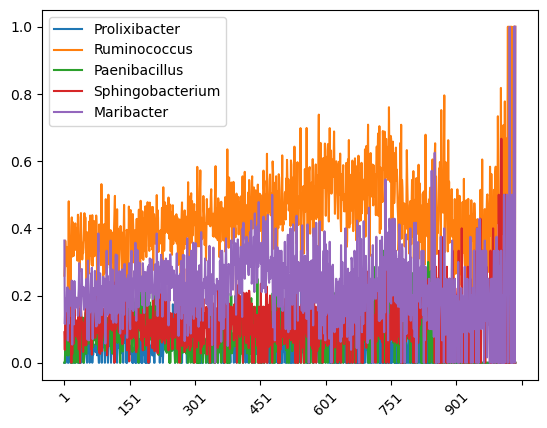

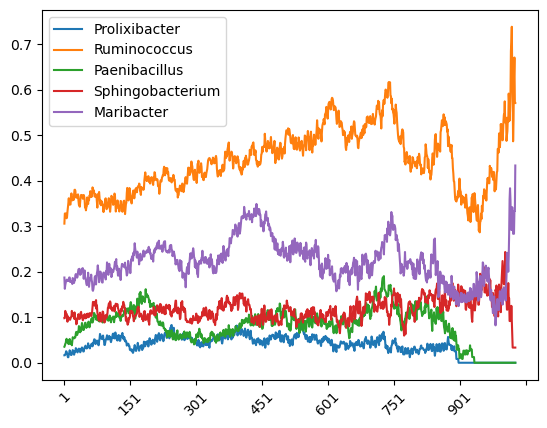

In [ ]:
# For the first mice (mice_diss[0])
genuses = np.asarray(mice_diss[0].index)
n_genuses = 5
rnd_idx = np.random.choice(np.arange(len(genuses)), n_genuses)
lags = np.asarray(mice_diss[0].columns)

for ge in genuses[rnd_idx]: 
    data = mice_diss[0].loc[ge].values
    plt.plot(lags, data, label = ge)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Let's smooth the data a bit for better visualization
def moving_average(data, window_size=5): #This means that for each point t, we take the average of the previous W points.
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

for ge in genuses[rnd_idx]: 
    data = mice_diss[0].loc[ge].values
    smoothed_data = moving_average(data, window_size=10)
    plt.plot(lags[:len(smoothed_data)], smoothed_data, label=ge)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
plot_dissimilarities_genus_in_pdf(mice_diss, n_genus_per_plot=5, window_size=10, ma = True)

PDF files already exist in Inspection_Outputs\dissimilarityplots_genus. Delete directory Inspection_Outputs\dissimilarityplots_genus to regenerate plots.


## Stationarity

REMEMBER: 

- a STATIONARY genus is one whose abundance fluctuates over time but always within some stable range or statistical pattern; 

- a NON-STATIONARY genus is one whose abundance drifts or trends over time systematically.

To discriminate between stationary and non-stationary abundancies we need to:

1. Perform a linear fit on data dissimilarities and save slopes, for each mouse and genus;

2. Set a threshold to classify if data dissimilarity is increasing or flat, corresponding to a non-stationary or stationary genus for a specific mouse;

3. Distinguish genera that have stationary dynamics from the others, visualize in a plot $\Phi_i(T)/\Phi_i^\infty$ vs T. 

In particular what we expect is that for stationary species, if you wait a long time, the dissimilarity won't be changing anylonger and the ratio $\Phi_i(T)/\Phi_i^\infty$ saturates. Instead for non-stationary species we'll have a $\Phi_i(T)$ continuously moving away from its earlier state. 


#### **LINEAR FIT OF DISSIMILARITIES**

NOTICE: we fit the dissimilarities linearly while dropping the initial transient, hence we consider only the part where it looks like we've reached "stationarity" and we check if it really is like that or not. 

In [ ]:
# Discard the initial transient (T > 10) 
for idx, mouse_df in enumerate(mice_diss): 
    mice_diss[idx] = mouse_df.drop(mouse_df.columns[:10], axis=1)

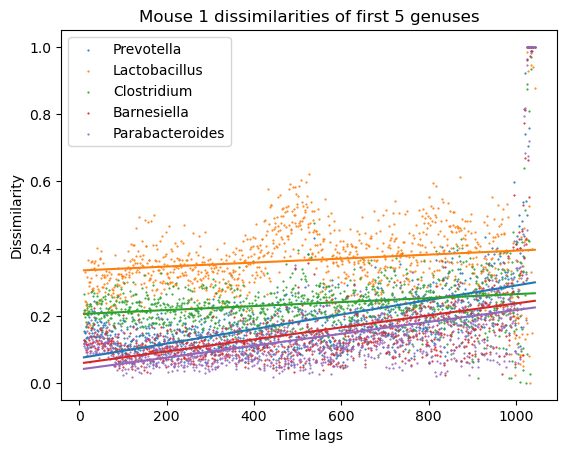

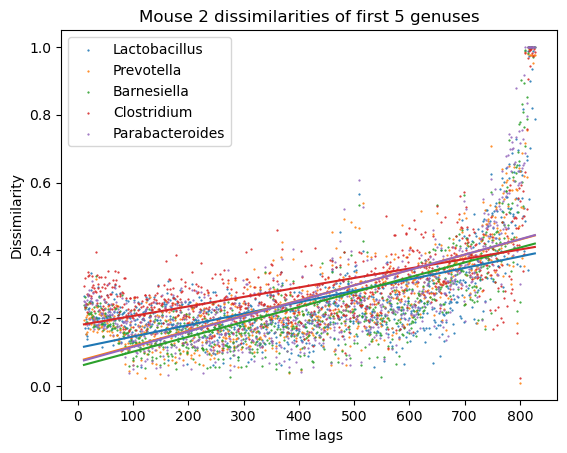

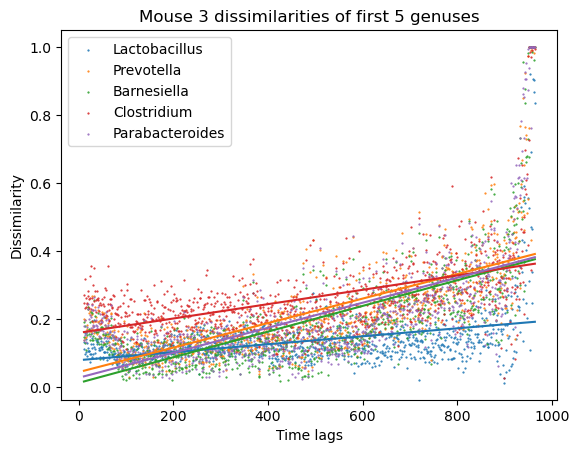

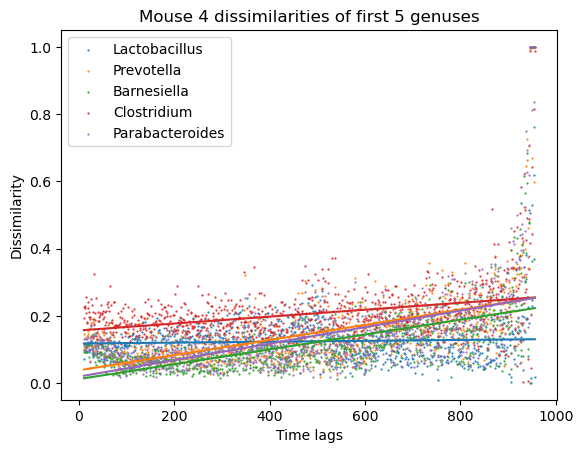

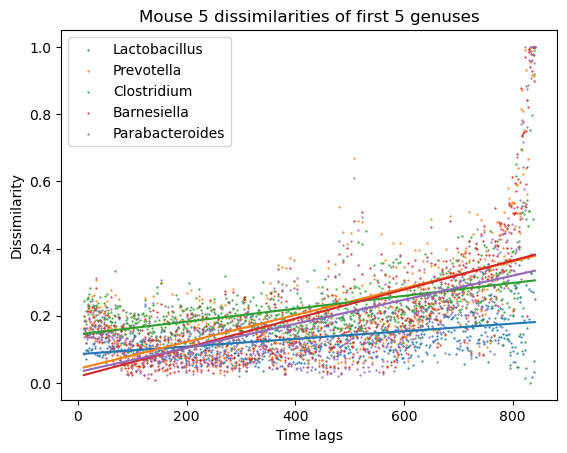

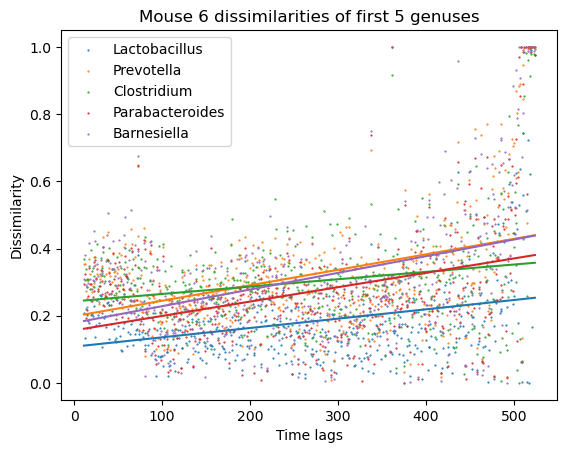

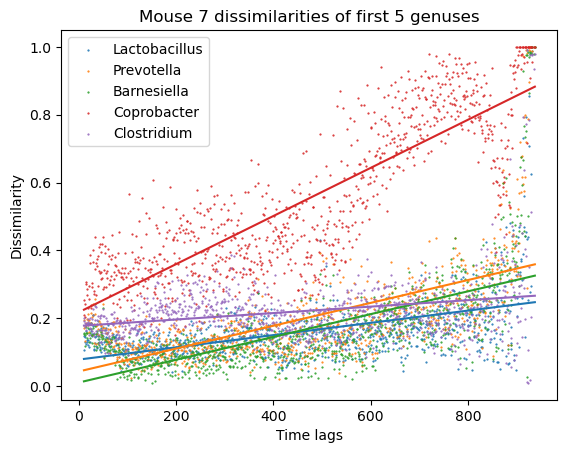

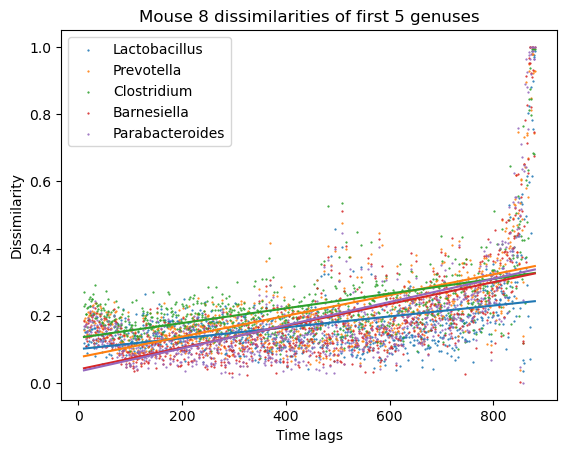

In [ ]:
# Perform a linear fit EXAMPLE for first 5 genuses for each mouse
for idx, mouse_df in enumerate(mice_diss): 
    data = mouse_df.head(5)
    ge_m = []
    ge_q = []
    ge_pred = []
    for ge_idx in range(len(data)): 
        ge_data = np.asarray(data.iloc[ge_idx, :])
        lags = np.asarray(data.columns, dtype = int)
        m, q, *_ = linregress(lags, ge_data)
        pred_data = m*lags + q
        ge_m.append(m)
        ge_q.append(q)
        ge_pred.append(pred_data)
        plt.scatter(lags, ge_data, s = 0.3, label = f'{mouse_df.index[ge_idx]}')
        plt.plot(lags, pred_data)
        plt.xlabel("Time lags")
        plt.ylabel("Dissimilarity")
    plt.title(f"Mouse {idx + 1} dissimilarities of first 5 genuses")
    plt.legend()
    plt.show()


In [ ]:
plot_dissfit_genus_in_pdf(mice_diss, n_genus_per_plot=5)


PDF files already exist in Inspection_Outputs\dissimilarityfit_genus. Delete directory Inspection_Outputs\dissimilarityfit_genus to regenerate plots.


#### **IDENTIFY THE THRESHOLD FOR INCREASING CURVES**

Always from the article: 

" _To establish the threshold, we accounted for the fact that, although we expect a flat dissimilarity if the abundance is stationary, a slope different from zero can be found because of the noise in the estimation of $\Phi$, which depends on the length and density of the time series, on the sequencing depth, and from the OTU parameters. Therefore, for each individual, we computed the threshold as follows:_

1.  _We simulated the dynamics of each OTU according to the SLM with parameters equal to the parameters estimated for that OTU and $\tau$ = 1_; 

2. _From these time series of $\vec{\lambda}$, we sampled the time series of $\vec{x}$ according to the sampling depth of the corresponding samples in the data, obtaining therefore values of $\vec{x}$ only for days for which the individual was sampled_; 

3. _We then computed_ $\tilde{\Phi}_i(T)$ _and its slope for each OTU. We defined as threshold for an individual the 95% quantile of the slopes obtained for that individual, i.e., the value such that only 5% of slopes obtained from the simulation are larger._" 

In practice, to set the threshold we :

1. Fit data abundancies into a LM, could be also a SLM, but computationally expensive and not necessary for next steps: better LM because easier to identify when stationarity is reached. We discard the ransient to stationarity from real data. 

2. From stationary abundancies estimate parameters with the theoretical values (from article): $\langle \lambda \rangle = K \frac{2 - \sigma}{\sigma}$, $\text{var}(\lambda) = \frac{\langle \lambda \rangle^2}{2 - \sigma}$; 

3. Sample simulated data on effective measurement days. From sampled simulated data compute simulated dissimilarity $\tilde{\Phi}_i(T)$ and its slope for each species. Set threshold for each mouse the 95% quantile of the slopes obtained for that individual on simulated data; classificate dissimilarity as increasing or flat.

NOTICE: If you **do not** select only the synthetic data corresponding to the days the real data was sampled, your **threshold estimation will be biased** because the noise characteristics of your simulated data will differ from the real dataset.

Including all synthetic data points instead of subsampling like the real data would introduce a bias by underestimating expected noise, leading to overly strict thresholds and false detection of trends.

In [ ]:
# PREPARE DATA FOR THE FIT (we want to fit abundancies, our epirical time series)
# Let's get the data cleaning it from the columns that do not correspond to genus names or abundancies
# Indeed if you print(mi.mice_df) you see there are other information not needed here

mice_ab = []
for mouse_num in range(1,9): 
    mice_df = pd.read_csv(f'Data/by_mouse_genus_aggregated/mouse_{mouse_num-1}_genus.csv')
    columns = mice_df.columns
    mice_ab.append(mice_df.drop(columns = ['median', 'mean']))
#print(mice_ab[0])

We define the functions for the fit with logistic model and for finding (and hence removing) the transient

In [ ]:
def lm_objective(params, time_series, dt):
    K, tau = params
    simulated_data = LM(ab0=time_series[0], K=K, tau=tau, steps=len(time_series)-1, dt=dt)
    
    if np.isnan(simulated_data).any():  
        return np.inf  # Large penalty value
    
    return np.sum((simulated_data - time_series)**2)  # Minimize MSE

def find_transient_end(time_series, window_size=10, threshold=0.01):
    variances = [np.var(time_series[i-window_size:i]) for i in range(window_size, len(time_series))]
    changes = np.abs(np.diff(variances))  # Change in variance, if small we reached stationarity
    
    for idx, change in enumerate(changes):
        if change < threshold:
            return idx + window_size  # Adjust index due to slicing

    return 0  # If no stable region is found, return 0 (keep all data)

# Define parameter bounds
bounds_K = (1, 1e3)  
bounds_tau = (0.5, 5.5)  
bounds = [bounds_K, bounds_tau]

We compute the parameters for all mice and genera by computing on data at stationarity both mean and variance

In [ ]:
# Store  parameters for all mice and genera
K_df, tau_df, sigma_df = params_to_csv(mice_ab, lm_objective, bounds, LM, find_transient_end, force_recompute=False)

PDF files already exist in Inspection_Outputs\LMfits. Delete directory Inspection_Outputs\LMfits to regenerate plots.
Loaded K, sigma, tau dataframes from csv files.


For each mice we compute the dissimilarity on the simulated data for each genus and the threshold on slopes of the linear fit of these curves. 

For clarity purposes here we plot only the first genus simulated data for each mice. 

In [ ]:
# DEFINE THE FUNCTIONS TO COMPUTE DISSIMILARITY AND THRESHOLD --> It's the same function that is in inspection.utils (maybe we can find a way to generalize)

def dissimilarity(simulated_series):
        dissimilarity_data=[]
        days=np.arange(0,len(simulated_series),1)
        valid_day_pairs = {T: {day for day in days if (day + T) in days} for T in range(1, len(simulated_series) + 1)}

# For each genus, compute dissimilarities by time lag
        for T in range(1, len(simulated_series) + 1):
                total_diss = 0
                count = 0
                for day in valid_day_pairs[T]:
                    diss_t = ((simulated_series[day] - simulated_series[day + T]) / 
                            max(1, (simulated_series[day] + simulated_series[day + T])))**2
                    total_diss += diss_t
                    count += 1

                # Only store dissimilarities for time lags with valid days
                if count > 0:
                    dissimilarity_data.append(total_diss / count)
                    
        return dissimilarity_data 

def threshold(start, K_df, sigma_df, df, mouse_num):
    """
    Compute the threshold based on simulated dissimilarity.
    
    Args:
    - start: Starting abundance index for each species.
    - K_df: DataFrame of carrying capacities (species x mice).
    - sigma_df: DataFrame of sigma values (species x mice).
    - df: Abundance DataFrame (species x time points).
    - mouse_num: Integer indicating which mouse's data to process.
    
    Returns:
    - threshold_value: 95th percentile of dissimilarity slopes.
    """
    slopes, sim_serie_diss = [], []

    genus_list = df.index  # Get species names

    # for species in species_list: 
    for geidx, genus in enumerate(genus_list): 
        measurement_days = np.asarray(df.columns[start[geidx]:], dtype=int)
        #if geidx == 0: 
             #print("start", start)
             #print("start shape", np.shape(start))
             #print("start[spidx]")
             # print("measurement days",measurement_days)
        # measurement_days = np.asarray(df.columns[start[specie]:], dtype=int)
        start_day = int(df.columns[start[geidx]])

        # Extract K and sigma values for this species & mouse
        K_val = K_df.loc[genus, f"Mouse {mouse_num+1}"]
        sigma_val = sigma_df.loc[genus, f"Mouse {mouse_num+1}"]

        # Simulate data with theoretical K and sigma
        time_steps = 0.1
        steps = len(measurement_days) * 10 *5  # Total simulation steps
        dt = np.full(steps, time_steps)  # Constant time step

        
        simulated_series = simulate_SLM(
            ab0=start[geidx],  
            K=K_val,
            sigma=sigma_val,
            tau=1.0,  
            steps=steps,
            dt=dt
        )
        
        # Extract simulated values for real measurement days
        nsteps_per_day = int(1 / time_steps)
        indexes_to_extract = np.clip((measurement_days - start_day) * nsteps_per_day, 0, len(simulated_series) - 1)
        simulated_series_sampled = simulated_series[indexes_to_extract]

        # Plot simulation results
        if genus == genus_list[0]:
            time_vals = np.linspace(start_day, steps * time_steps, steps + 1)
            plt.plot(time_vals, simulated_series, label="Stochastic Logistic Model", zorder=1)
            plt.scatter(measurement_days, simulated_series_sampled, color="red", s=20, label="Extracted days", zorder=2)
            plt.xlabel("Time")
            plt.ylabel("Abundance")
            plt.title(f"Simulated SLM sampled as {genus} in mouse {mouse_num+1}")
            plt.legend()
            plt.show()

        # Compute dissimilarity and extract threshold
        simulated_series_diss = dissimilarity(simulated_series_sampled)
        sim_serie_diss.append(simulated_series_diss)

        if genus == genus_list[0]:  # Plot only for the first genus
            plt.scatter(np.arange(len(simulated_series_diss)), simulated_series_diss)
            plt.xlabel("Time Lags")
            plt.ylabel("Dissimilarity")
            plt.title("Simulated series dissimilarity")
            plt.show()

        slope, _, _, _, _ = linregress(np.arange(len(simulated_series_diss)), simulated_series_diss)
        slopes.append(abs(slope))  # Ensure positive slopes

    #threshold_value = np.percentile(slopes, 95)  # 95th percentile as threshold
    threshold_value = np.percentile(slopes, 75)  # 95th percentile as threshold
    return threshold_value


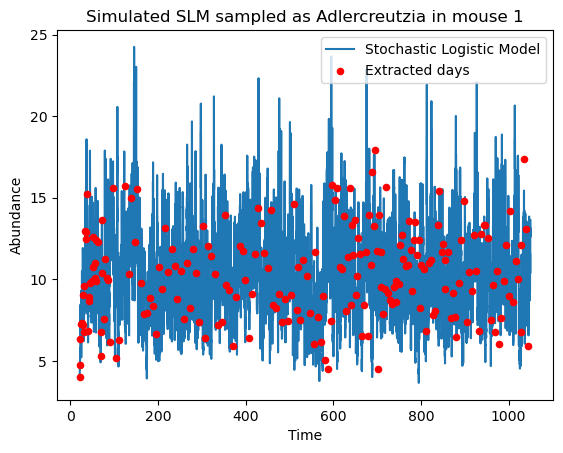

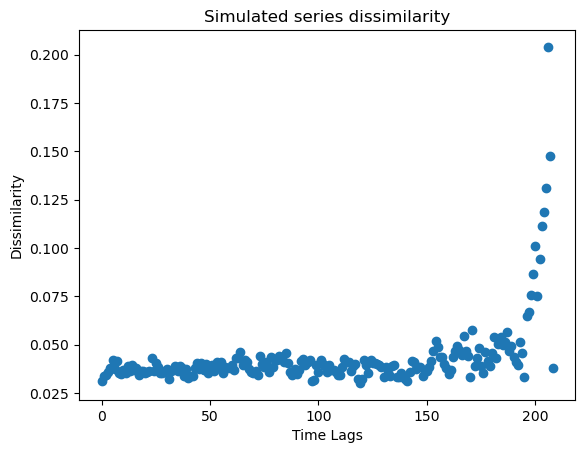

Processing Mouse 1, obtained threshold: 0.0007788337791790027
Trends for Mouse 1 appended to dataframe


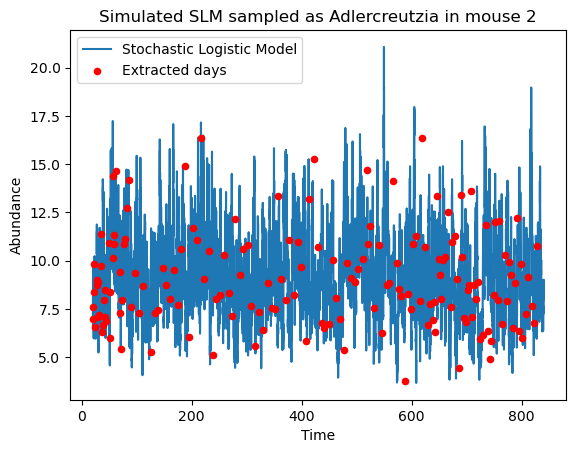

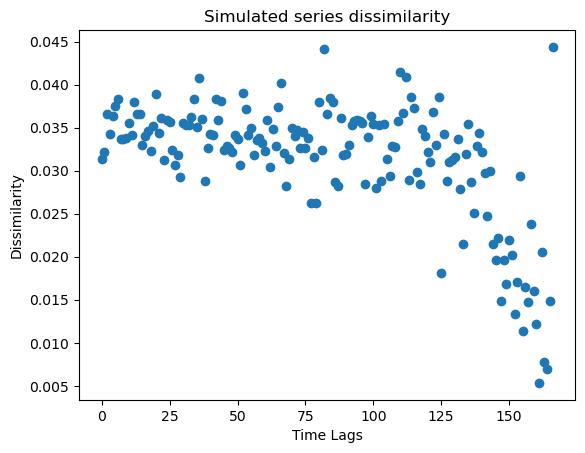

Processing Mouse 2, obtained threshold: 0.00047123599685107225
Trends for Mouse 2 appended to dataframe


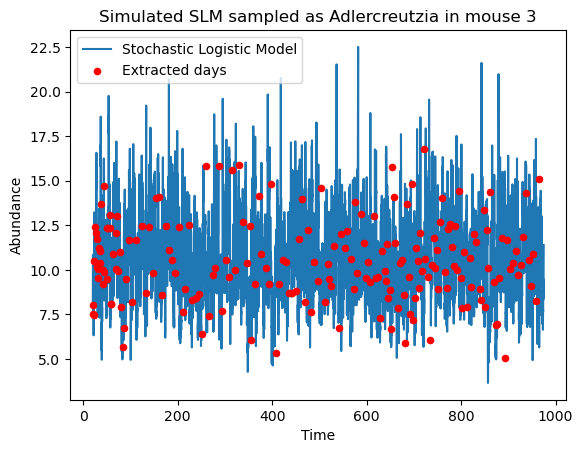

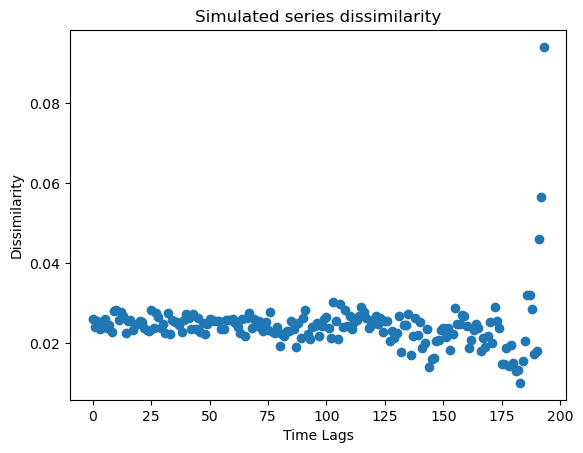

Processing Mouse 3, obtained threshold: 0.0005703318381164021
Trends for Mouse 3 appended to dataframe


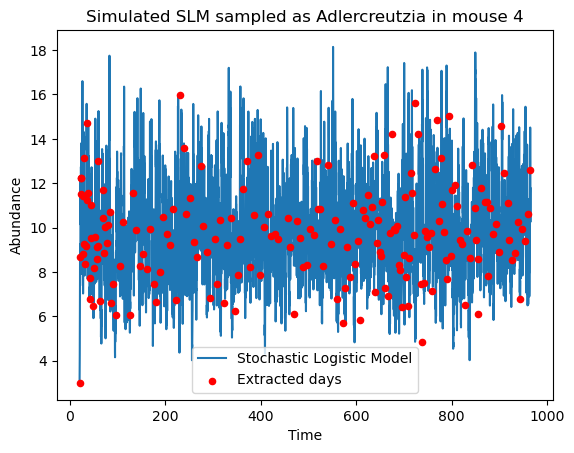

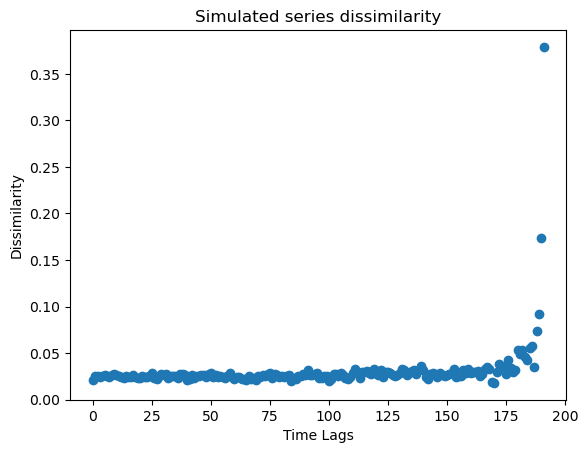

Processing Mouse 4, obtained threshold: 0.0006105975729929601
Trends for Mouse 4 appended to dataframe


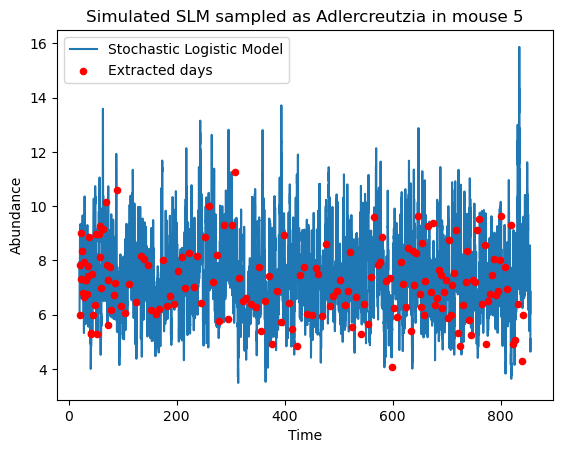

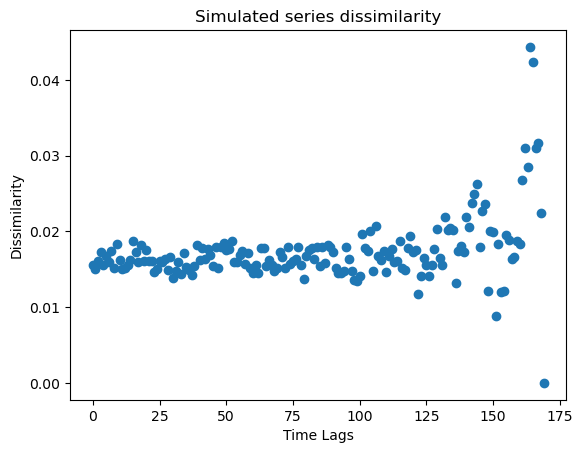

Processing Mouse 5, obtained threshold: 0.0007265488716323058
Trends for Mouse 5 appended to dataframe


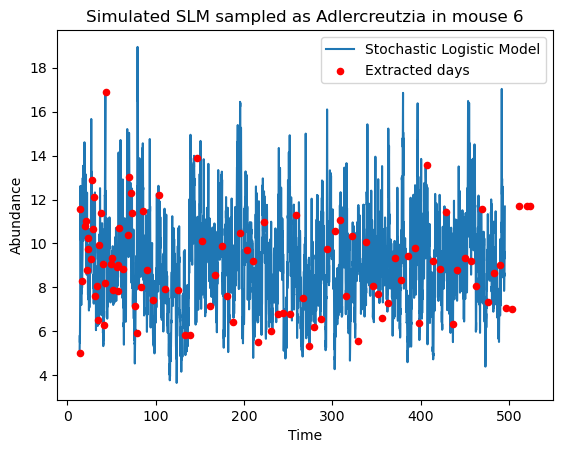

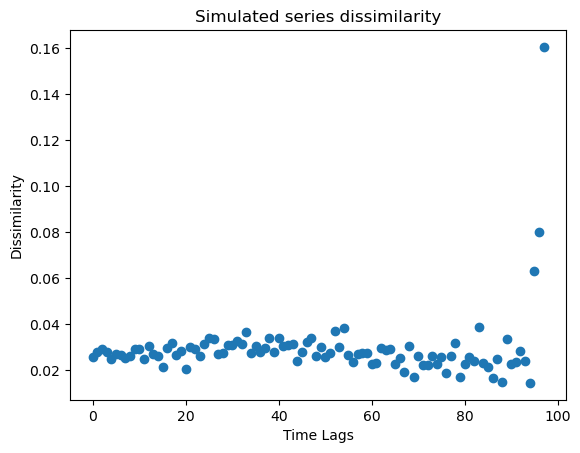

Processing Mouse 6, obtained threshold: 0.001914818473802522
Trends for Mouse 6 appended to dataframe


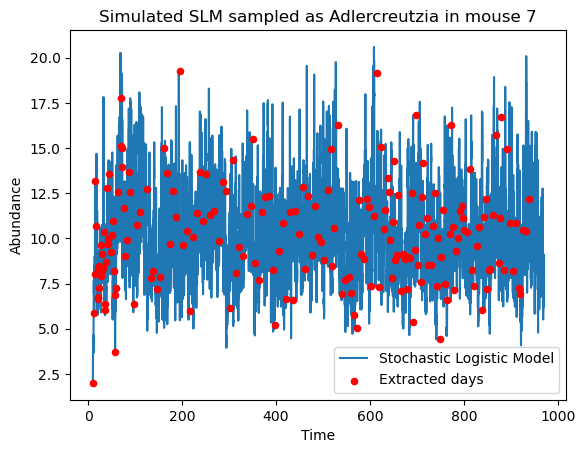

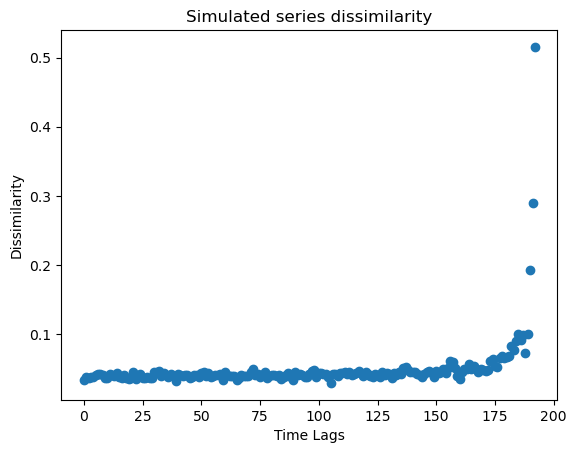

Processing Mouse 7, obtained threshold: 0.000515600794770199
Trends for Mouse 7 appended to dataframe


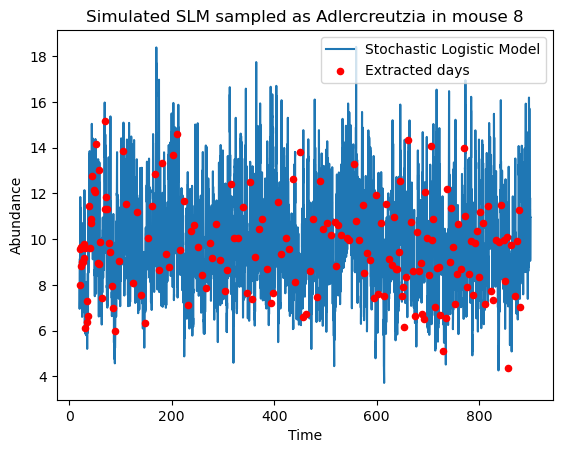

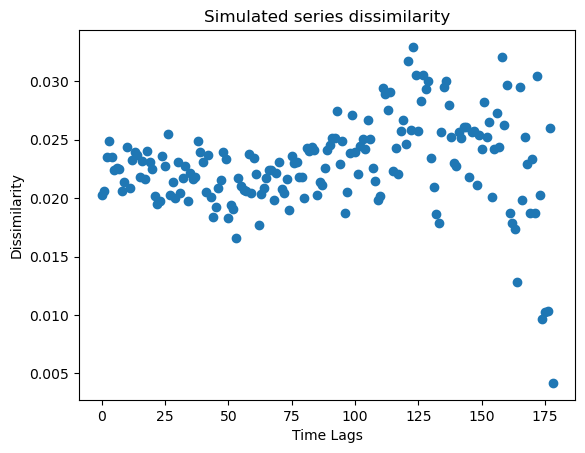

Processing Mouse 8, obtained threshold: 0.0007223592819441123
Trends for Mouse 8 appended to dataframe


In [ ]:
# Iterate through all mice
# Extract the DataFrame for the current mouse
    
mask= np.any(K_df.isna(),axis=1)
K_filtered = K_df[~mask]
sigma_filtered = sigma_df[~mask]


summary_df = []
for mouse_idx, mouse in enumerate(mice_diss):
    
    # Remove the "TREND" column if it exists (to allow re-running the code)
    if 'TREND' in mouse.columns:
        mouse = mouse.drop(columns=['TREND'], inplace=True)  # Avoid inplace modifications

    df = mice_ab[mouse_idx] 
    df.index=df['Genus']
    K_filtered.index=K_filtered['Genus']
    sigma_filtered.index=sigma_filtered['Genus']
    species_in_both = df.index.intersection(K_filtered.index)
    species_in_both=species_in_both.sort_values() 
    df_filtered = df.loc[species_in_both]


    K_filtered = K_filtered.loc[species_in_both]
    sigma_filtered = sigma_filtered.loc[species_in_both]
 
    # Extract abundance data (excluding metadata columns)
    abundance_data = df_filtered.iloc[:, 1:].to_numpy()

    # Find species with at least one nonzero abundance at any time point
    nonzero_species = np.any(abundance_data > 0, axis=1) 

    if np.sum(nonzero_species) == 0:  # No species with nonzero values
        print(f"Skipping Mouse {mouse_idx + 1} (no nonzero species)")
        summary_df.append(pd.DataFrame())  # Append empty DataFrame for consistency
        continue  

    # For each species, find the index of the first nonzero time point.
    first_nonzero_idx = np.argmax(abundance_data > 0, axis=1)

    # Optionally, handle species that are always zero:
    # first_nonzero_indices = np.where(nonzero_species, first_nonzero_indices, -1)

    # Select the first species that has nonzero abundance
    first_nonzero_idx = np.where(nonzero_species, np.argmax(abundance_data > 0, axis = 1), -1)

    # Ensure indices are within the valid range
    first_nonzero_idx = np.clip(first_nonzero_idx, 0, abundance_data.shape[1] - 1)
    

    # Compute the threshold for the current mouse
    threshold_mouse = threshold(
        #start=start_values,
        start = first_nonzero_idx,
        K_df=K_filtered,  # Pass K values
        sigma_df=sigma_filtered,  # Pass sigma values
        df=df_filtered.iloc[:, 4:],  # Pass only the abundance data
        mouse_num=mouse_idx
    )

    print(f"Processing Mouse {mouse_idx + 1}, obtained threshold: {threshold_mouse}")

    # Store trends for each species
    trend = []

    # Iterate over species in the mouse dataset
    for spec_idx, spec in enumerate(df_filtered.index):  
        time_diss = mouse.loc[spec]

        # Compute the slope using linear regression
        slope_mouse, _, _, _, _ = linregress(np.arange(len(time_diss)), time_diss)

        # Determine the trend based on threshold
        trend.append("incr" if slope_mouse > threshold_mouse else "flat")

    diss_inf_values = sigma_filtered[f"Mouse {mouse_idx + 1}"] / (4 - sigma_filtered[f"Mouse {mouse_idx + 1}"])

    temp_df = pd.DataFrame({
        'TREND': trend,
        'K': K_filtered[f"Mouse {mouse_idx + 1}"].values.flatten(),
        'sigma': sigma_filtered[f"Mouse {mouse_idx + 1}"].values.flatten(),
        'diss_inf': diss_inf_values.values.flatten()
    }, index=species_in_both)

    # Append to summary DataFrame
    summary_df.append(temp_df)

    # Append trend classification to the DataFrame
    mouse.loc[species_in_both]["TREND"] = trend

    print(f"Trends for Mouse {mouse_idx + 1} appended to dataframe")


#### **PLOT $\Phi_i(T) / \Phi_i(\infty)$ RATIO**

In [ ]:
#print(mice_diss[0])
normalized_diss_list, mean_non_normalized_diss =[], []

for mouse_idx in range(len(mice_diss)):
    # printing species with increasing trend
    print("Mouse", mouse_idx, summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'incr'].index)

    #  Extract dissimilarity data for species listed in the summary DataFrame
    selected_species=summary_df[mouse_idx].index
    selected_diss=mice_diss[mouse_idx].loc[selected_species]

    # Normalize dissimilarity by the value it'd have at infinity
    normalized_diss = selected_diss.div(summary_df[mouse_idx]['diss_inf'], axis=0)  # Element-wise division

    # Store for this mouse normalized dissimilarity matrix
    normalized_diss_list.append(normalized_diss)  

    # Store for this mouse a DataFrame pairing species names with their mean dissimilarity
    species_names = normalized_diss.index.tolist()
    mean_non_normalized= np.mean(selected_diss, axis=0)
    mean_non_normalized_diss.append(pd.DataFrame(zip(species_names, mean_non_normalized)))

Mouse 0 Index([], dtype='object', name='Genus')
Mouse 1 Index(['Candidatus Arthromitus', 'Eubacterium'], dtype='object', name='Genus')
Mouse 2 Index([], dtype='object', name='Genus')
Mouse 3 Index([], dtype='object', name='Genus')
Mouse 4 Index(['Aureibacter', 'Coprobacter'], dtype='object', name='Genus')
Mouse 5 Index([], dtype='object', name='Genus')
Mouse 6 Index(['Coprobacter', 'Eubacterium', 'Parasutterella'], dtype='object', name='Genus')
Mouse 7 Index([], dtype='object', name='Genus')


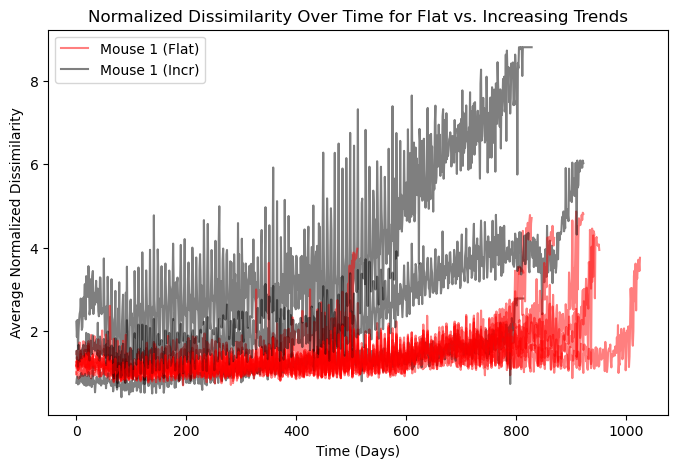

In [ ]:
# Create figure
plt.figure(figsize=(8, 5))

# Iterate through each mouse
for mouse_idx in range(len(mice_diss)):
    if summary_df[mouse_idx].empty or normalized_diss_list[mouse_idx].empty:
        print(f"Skipping Mouse {mouse_idx + 1} (empty data)")
        continue

    # Select species based on TREND
    flat_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'flat'].index
    incr_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'incr'].index

    # Compute mean dissimilarity across species (rows) for each trend
    mean_diss_flat = normalized_diss_list[mouse_idx].loc[flat_species].mean(axis=0)  
    mean_diss_incr = normalized_diss_list[mouse_idx].loc[incr_species].mean(axis=0)  

    # X-axis: time points
    time_points = np.arange(len(mean_diss_flat))

    # Plot for the current mouse
    plt.plot(time_points, mean_diss_flat, linestyle='-', color='red', alpha=0.5, label=f'Mouse {mouse_idx+1} (Flat)' if mouse_idx == 0 else "")
    plt.plot(time_points, mean_diss_incr, linestyle='-', color='black', alpha=0.5, label=f'Mouse {mouse_idx+1} (Incr)' if mouse_idx == 0 else "")

# Labels and title
plt.xlabel("Time (Days)")
plt.ylabel("Average Normalized Dissimilarity")
plt.title("Normalized Dissimilarity Over Time for Flat vs. Increasing Trends")
plt.legend()
plt.show()


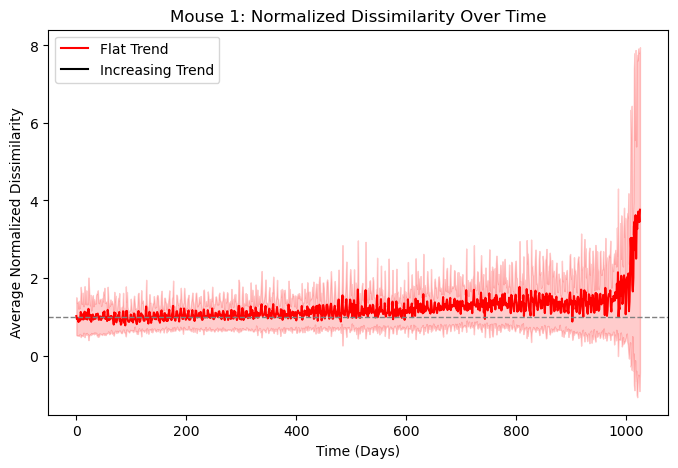

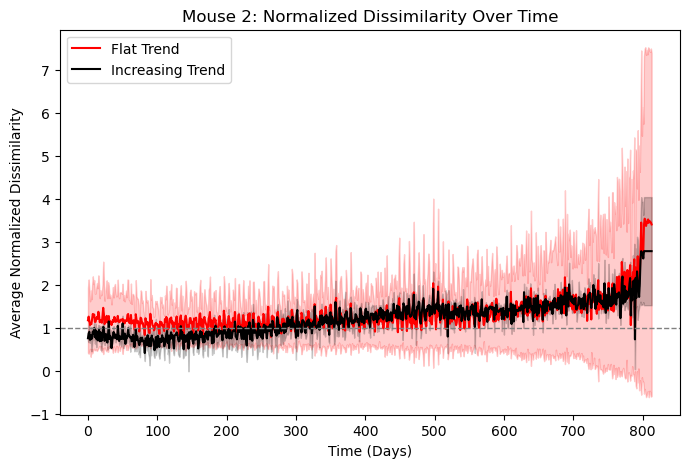

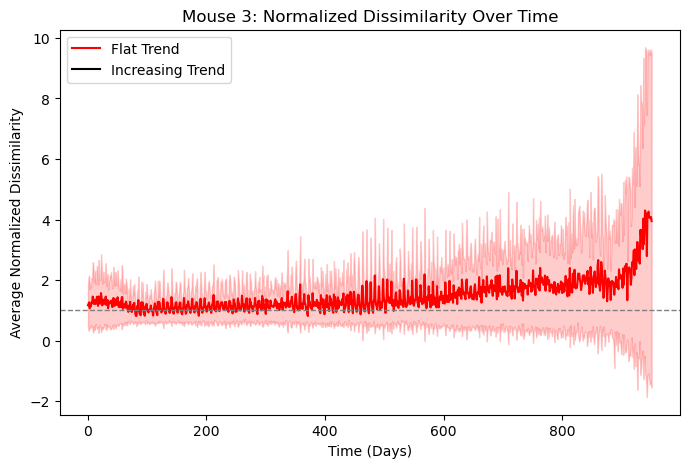

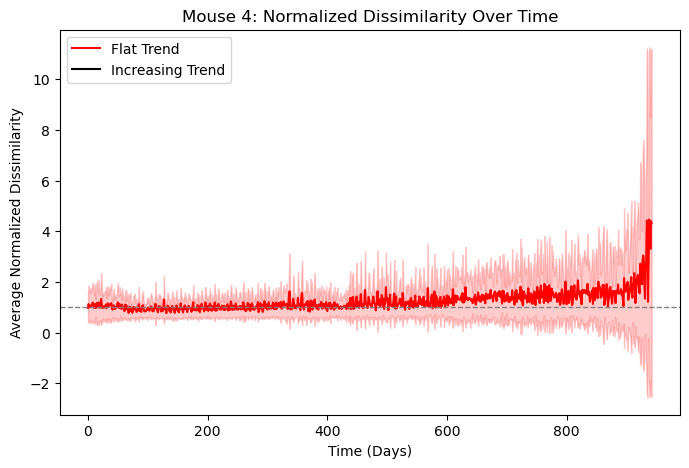

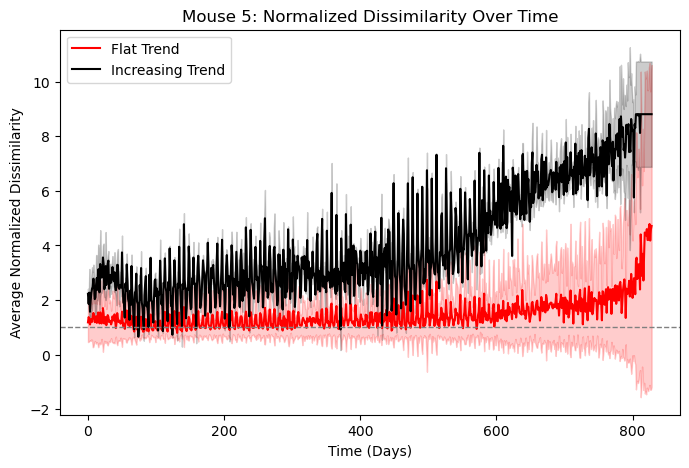

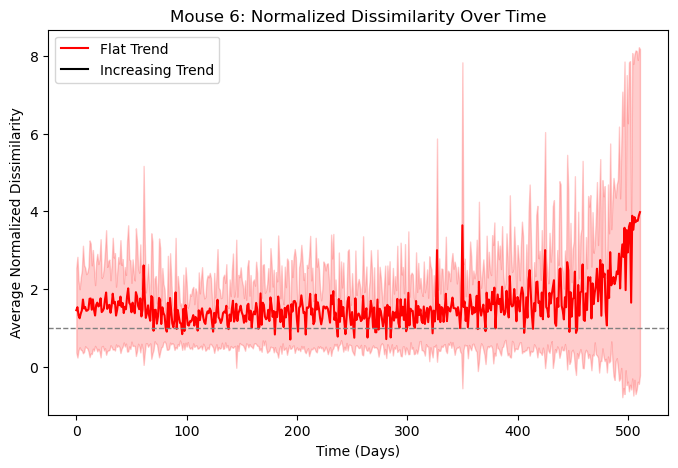

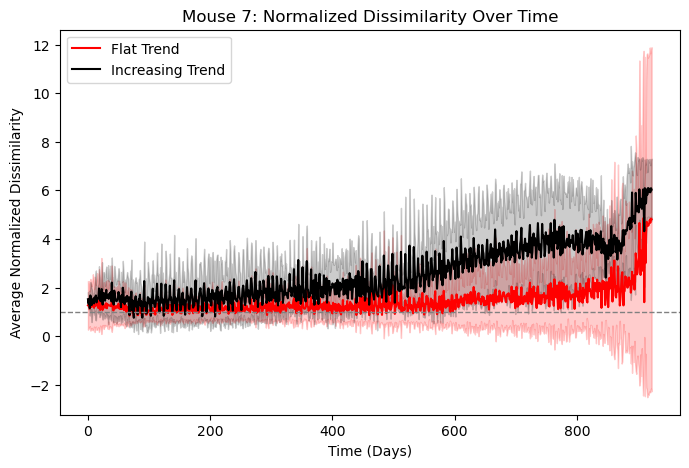

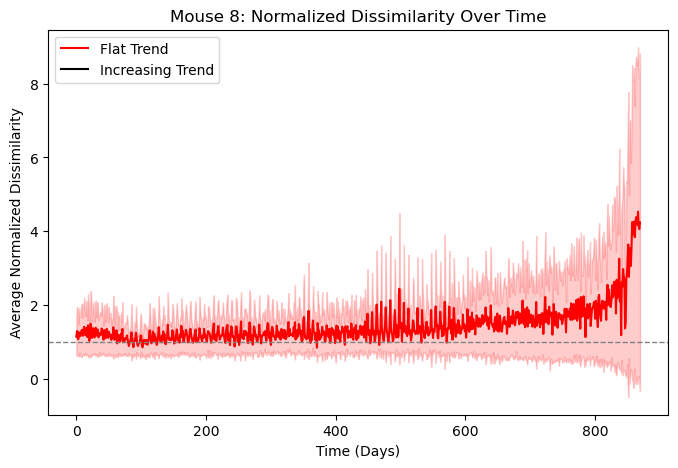

In [ ]:
# Iterate through each mouse
for mouse_idx in range(len(mice_diss)):
    if summary_df[mouse_idx].empty or normalized_diss_list[mouse_idx].empty:
        print(f"Skipping Mouse {mouse_idx + 1} (empty data)")
        continue

    # Select species based on TREND
    flat_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'flat'].index
    incr_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'incr'].index

    # Compute mean and standard deviation across species for each trend
    mean_diss_flat = normalized_diss_list[mouse_idx].loc[flat_species].mean(axis=0)  
    std_diss_flat = normalized_diss_list[mouse_idx].loc[flat_species].std(axis=0)

    mean_diss_incr = normalized_diss_list[mouse_idx].loc[incr_species].mean(axis=0)  
    std_diss_incr = normalized_diss_list[mouse_idx].loc[incr_species].std(axis=0)

    # X-axis: time points
    time_points = np.arange(len(mean_diss_flat))

    # Create a new figure for each mouse
    plt.figure(figsize=(8, 5))

    # Plot mean dissimilarities
    plt.plot(time_points, mean_diss_flat, linestyle='-', color='red', label='Flat Trend')
    plt.plot(time_points, mean_diss_incr, linestyle='-', color='black', label='Increasing Trend')

    # Add shaded region (Mean ± SD)
    plt.fill_between(time_points, mean_diss_flat - std_diss_flat, mean_diss_flat + std_diss_flat, color='red', alpha=0.2)
    plt.fill_between(time_points, mean_diss_incr - std_diss_incr, mean_diss_incr + std_diss_incr, color='black', alpha=0.2)

    # Add a horizontal dashed line at y = 1
    plt.axhline(y=1, color='gray', linestyle='dashed', linewidth=1)

    # Labels and title
    plt.xlabel("Time (Days)")
    plt.ylabel("Average Normalized Dissimilarity")
    plt.title(f"Mouse {mouse_idx + 1}: Normalized Dissimilarity Over Time")
    plt.legend()

    # Show plot for this mouse
    plt.show()



## 5. **Taxonomic analysis on species with nonstationary behaviour**
Perform a taxonomic analysis on species with nonstationary behaviour



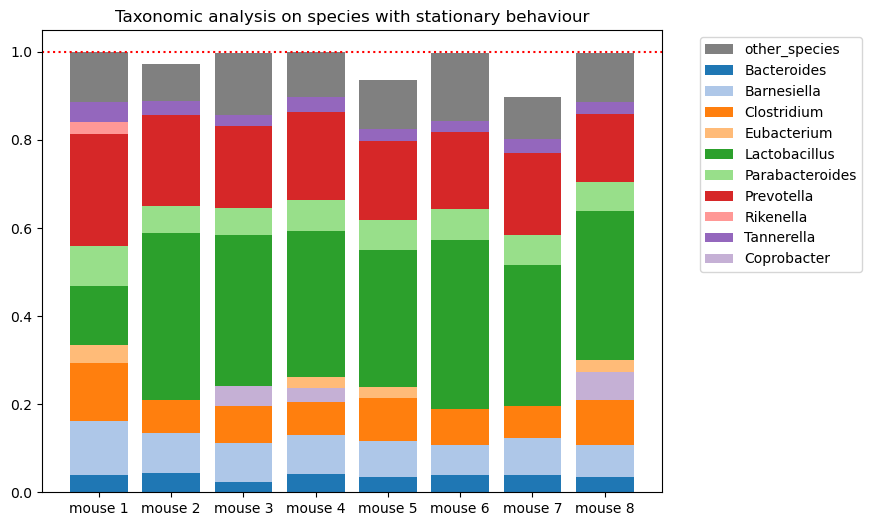

In [ ]:
def Taxonomic_analysis(lista):  

    median_count=[]
    species_colors = {}    
    legend_handles = {}
    
    fig, ax = plt.subplots(figsize=(8, 6))
    c=0
    color_palette = plt.cm.tab20.colors 

    for i in range(8):
      
        path=f"Data/by_mouse_genus_aggregated/mouse_{i}_genus.csv"
        file=pd.read_csv(path) 
      
        bottom=0
        other_species=0
        
        max_median=np.sum(file["median"])   
        
        for spec in lista[i]:       
           
            median_count=(file["median"][file["Genus"]==spec]).values
            median_ratio=median_count/max_median
            
            if  (median_count==0) or (np.isnan(median_count)):
                continue
            elif median_ratio<50/max_median:
                other_species+=median_ratio
            else:
                if spec not in species_colors:
                    species_colors[spec] = color_palette[len(species_colors) % len(color_palette)]
                    
                bar = ax.bar(f"mouse {i+1}", median_ratio, bottom=bottom, color=species_colors[spec])
            
                if spec not in legend_handles:
                    legend_handles[spec] = bar[0]
                
                
                bottom +=median_ratio  # Update the "bottom" for stacking
            if other_species > 0:
                bar_other = ax.bar(f"mouse {i+1}", other_species, bottom=bottom, color="gray")

                if "other_species" not in legend_handles:
                    legend_handles["other_species"] = bar_other[0]
   
    #ax.bar(f"mouse {i+1}", other_species, label="other_increasing_species", bottom=bottom)
    ax.set_title("Taxonomic analysis on species with stationary behaviour")      
    ax.axhline(1,c="red",linestyle='dotted')        
    ax.legend(legend_handles.values(), legend_handles.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    return None

flat_list = [df[df["TREND"] == "flat"].index.tolist() for df in summary_df]
incr_list = [df[df["TREND"] == "incr"].index.tolist() for df in summary_df]

Taxonomic_analysis(flat_list)
#Taxonomic_analysis(incr_list)

## 6. **Estimate the parameters of SLM for stationary species**

Estimate the model parameters $K$ and $\sigma$, from the relations: 

$\left<\lambda\right>=K\left(\frac{2-\sigma}{2}\right)$ and $Var(\lambda)= \left( \frac{\sigma}{2-\sigma} \right) \left<\lambda\right>^2$

- if $\sigma<2$, the stationary distribution is gamma $$P(\lambda; K, \sigma) = \frac{1}{\Gamma (2/\sigma -1)} \left(\frac{2}{\sigma K}\right)^{2/\sigma -1} \lambda^{2/\sigma-2} e^{-\frac{2}{\sigma K}\lambda} $$
so we can produce a histogram out of our data and superimpose the theoretical pdf; perform test on distribution.

calculate theoretical expectation value for the dissimilarity at stationarity $\mathbb{E}[\Phi_i^\infty]=\frac{\sigma}{4-\sigma}$, compare with the mean of dissimilarity computed from data.

In [ ]:
#print(mice_diss[0])
mean_non_normalized_diss =[]

for mouse_idx in range(len(mice_diss)):
    #  Extract dissimilarity data for species listed in the summary DataFrame
    selected_species=summary_df[mouse_idx].index
    selected_diss=mice_diss[mouse_idx].loc[selected_species]

    # Store for this mouse a DataFrame pairing species names with their mean dissimilarity
    species_names = normalized_diss.index.tolist()
    mean_non_normalized= np.mean(selected_diss, axis=0)
    mean_non_normalized_diss.append(pd.DataFrame(zip(species_names, mean_non_normalized)))

In [ ]:
def confrontation(sigma, mean):

    expected = sigma / (4 - sigma)
    absolute_error = abs(expected - mean)
    relative_error = (absolute_error / expected) * 100

    return(expected ,relative_error)

def gamma_pdf(lambda_val, K, sigma):
    shape_param = (2 / sigma) - 1
    scale_param = 1 / (K * shape_param)
    return gamma.pdf(lambda_val, a=shape_param, scale=scale_param)


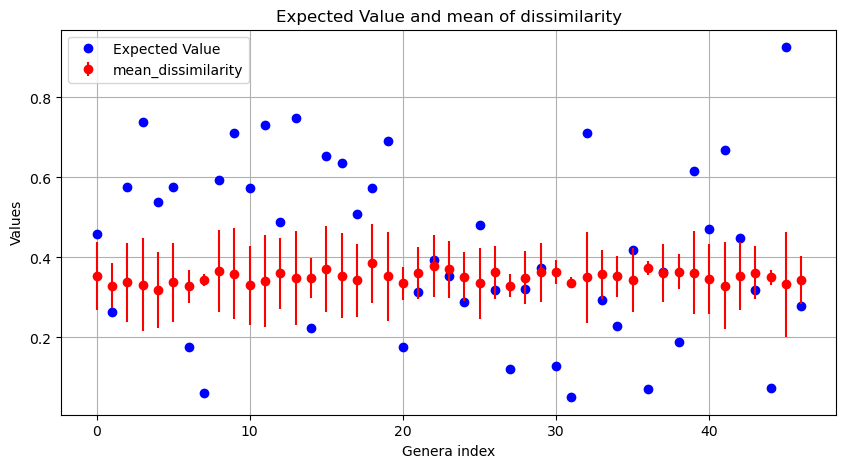

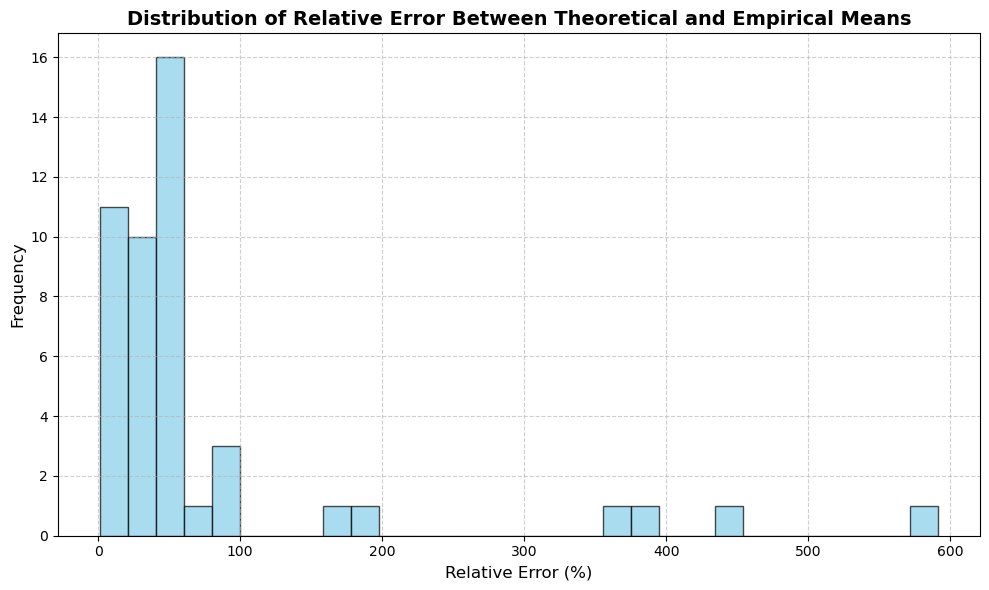

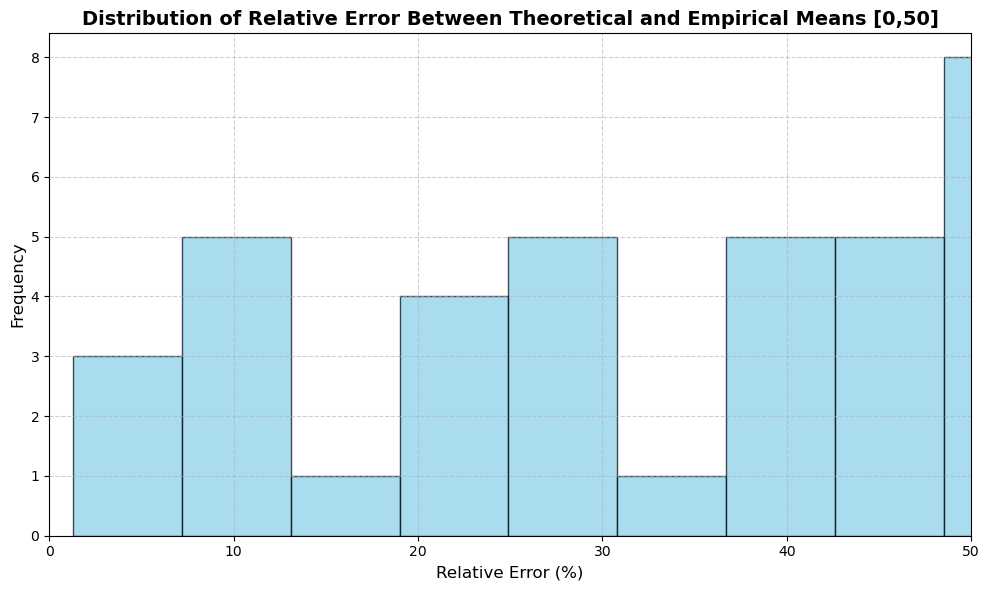

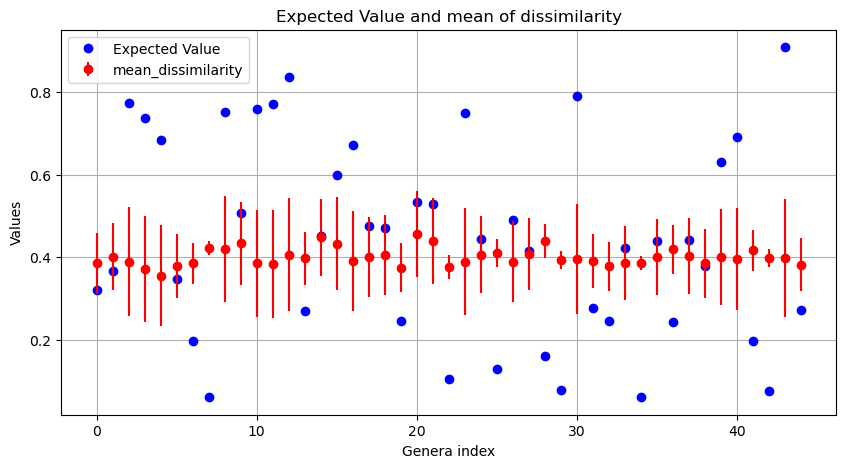

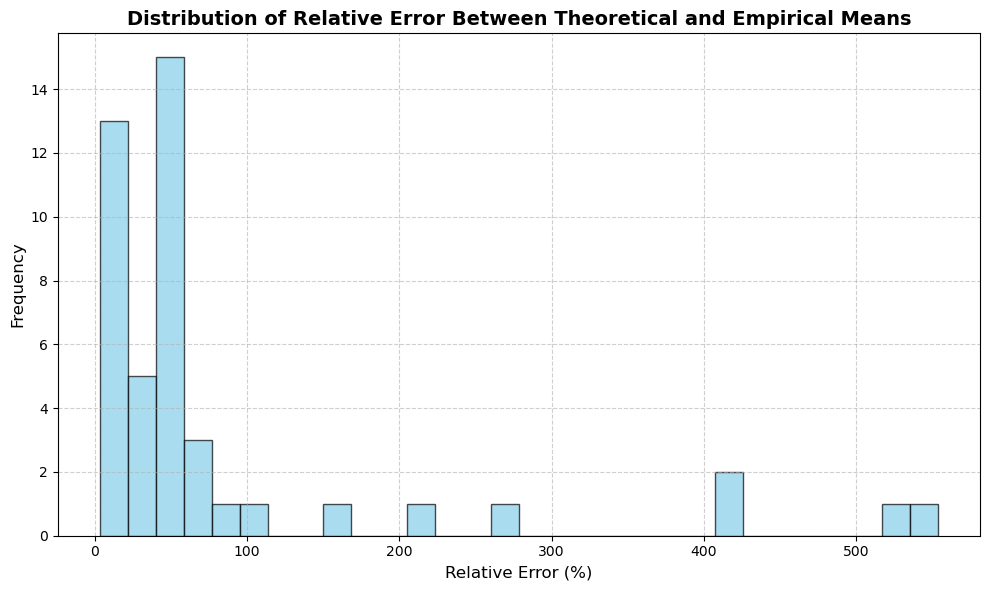

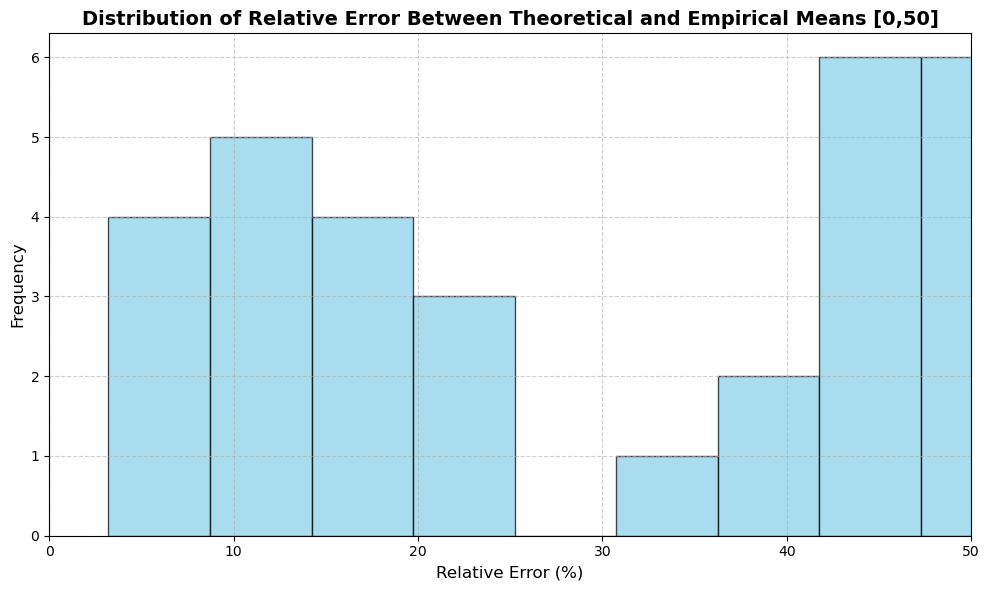

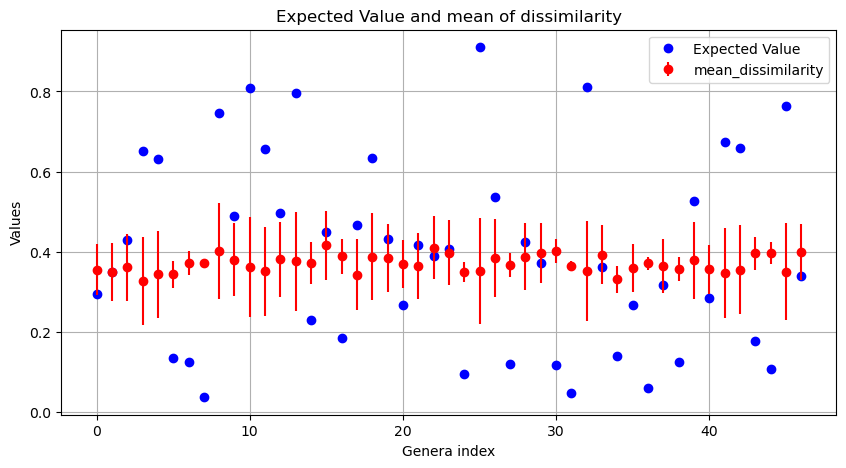

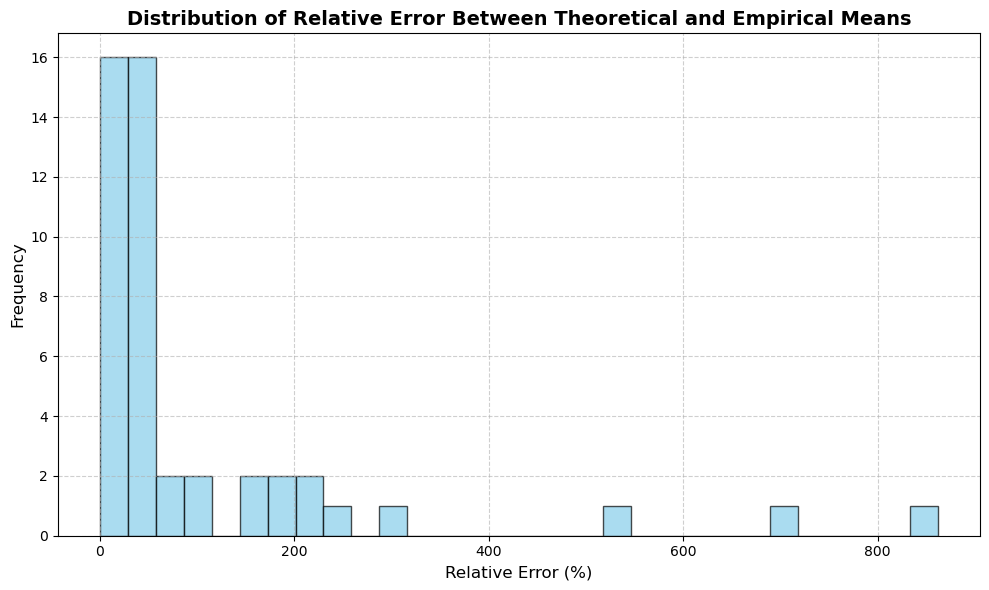

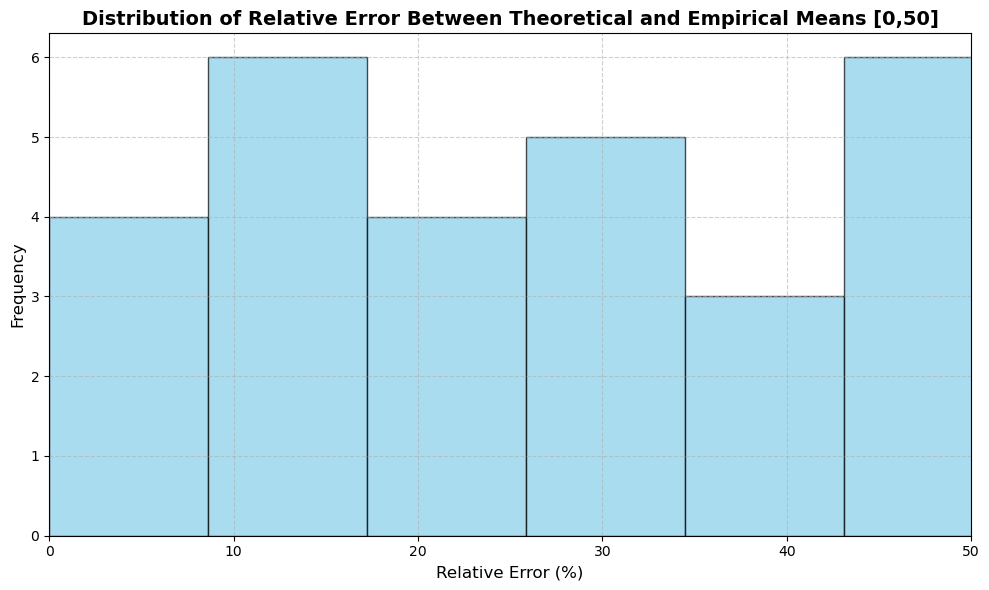

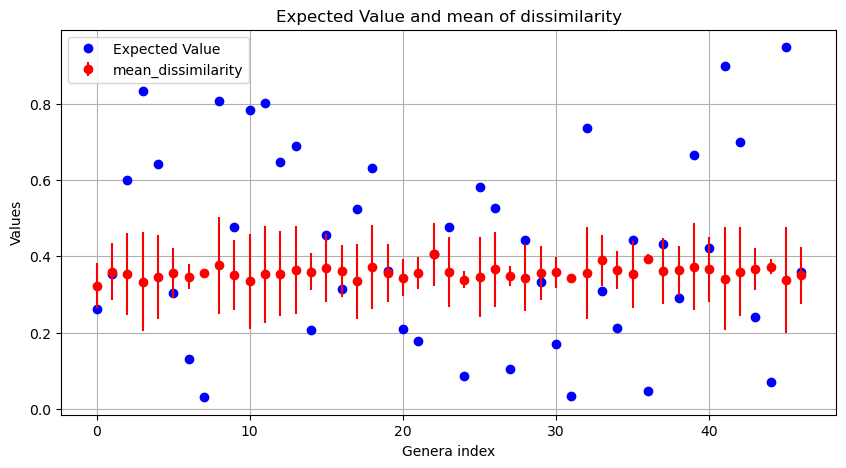

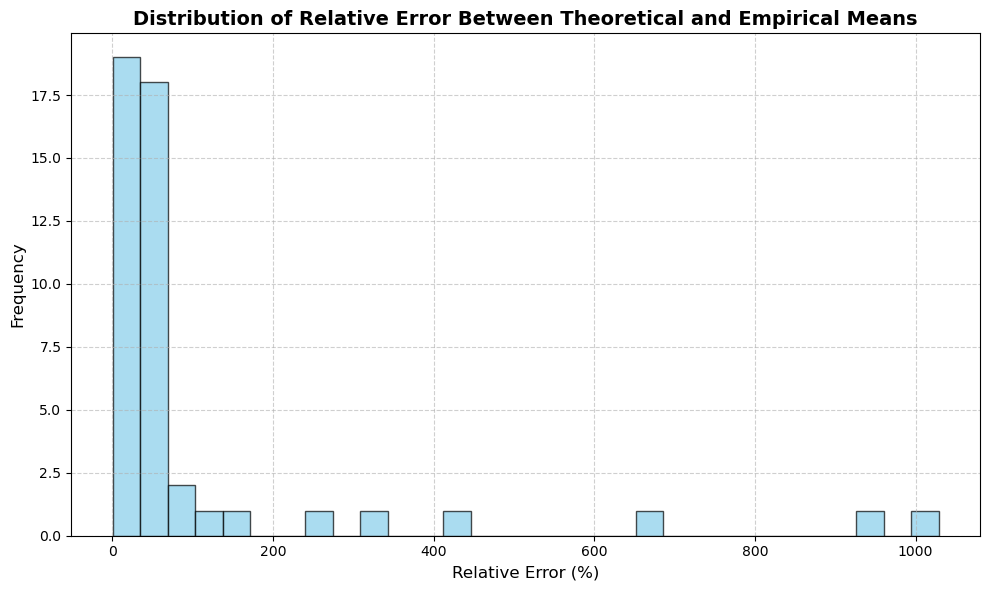

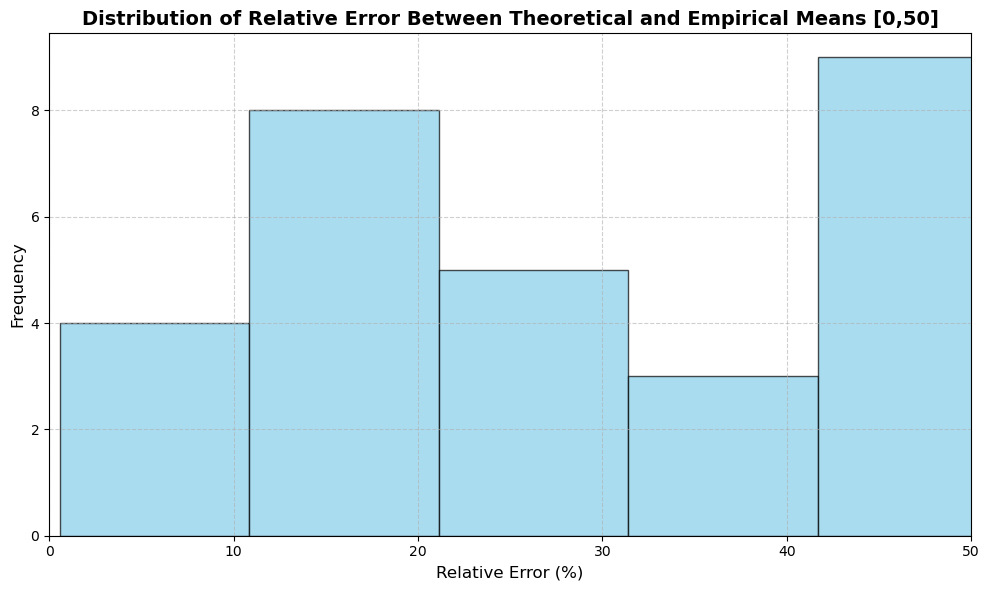

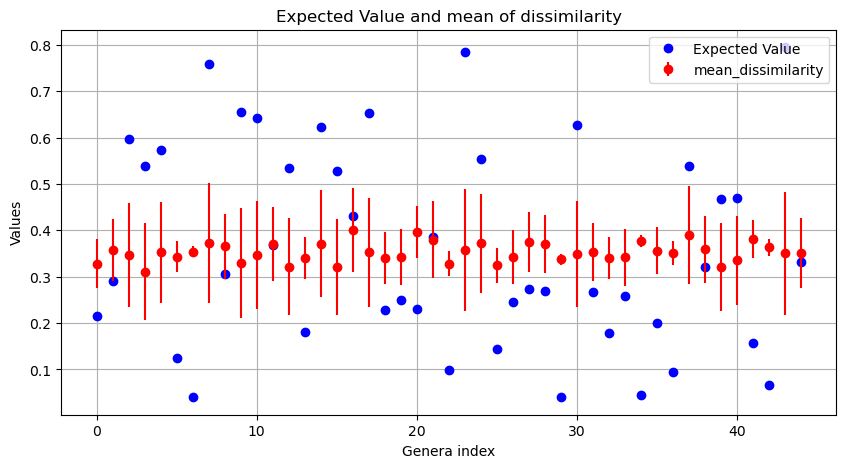

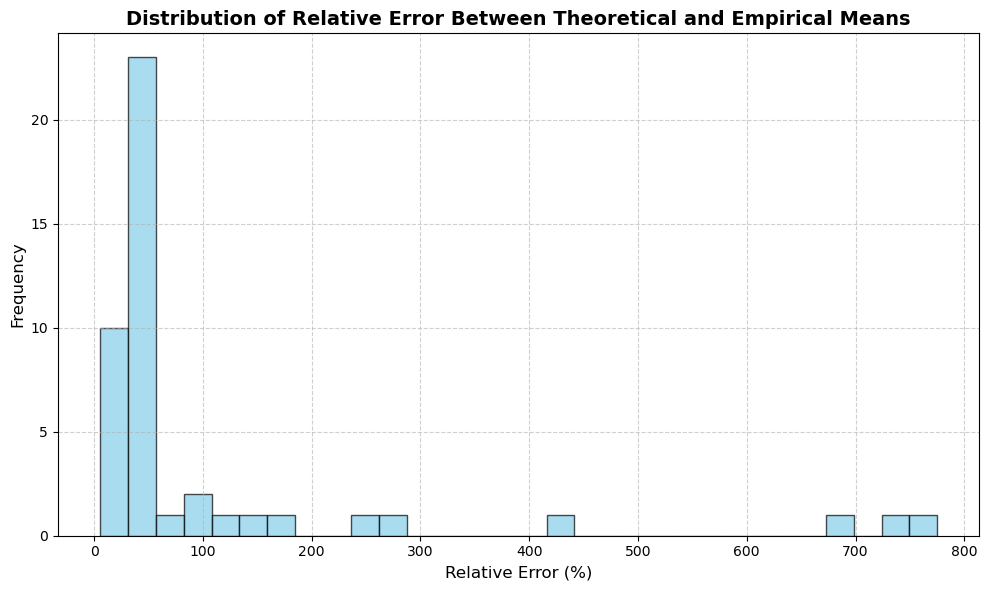

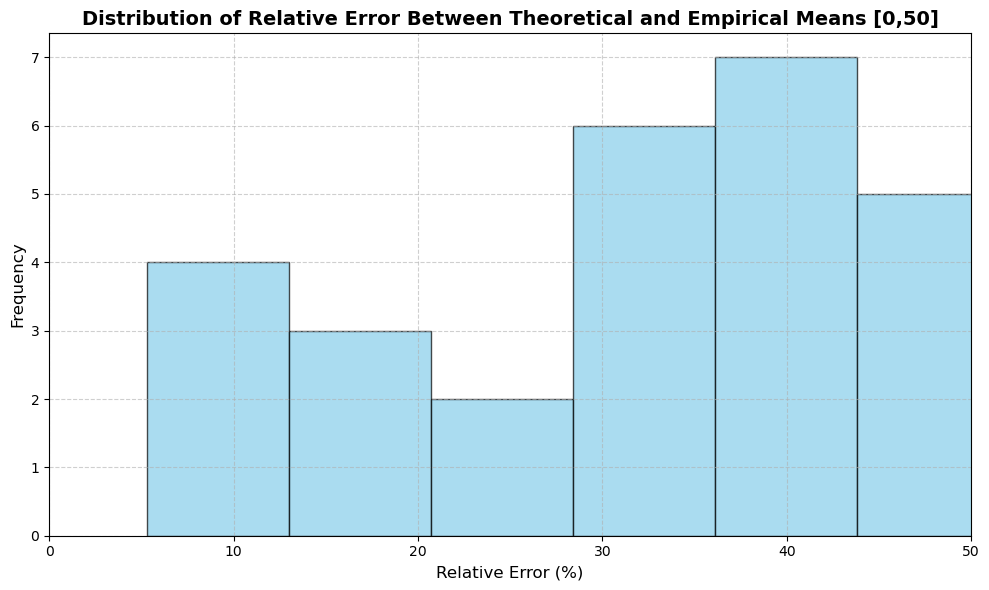

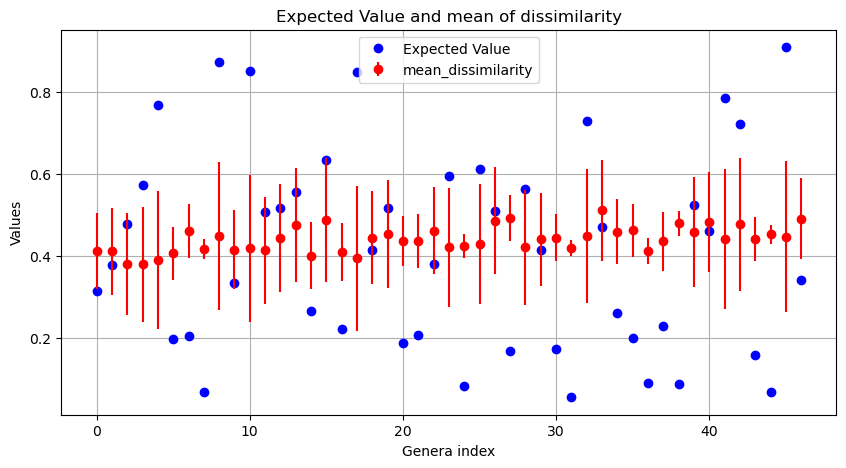

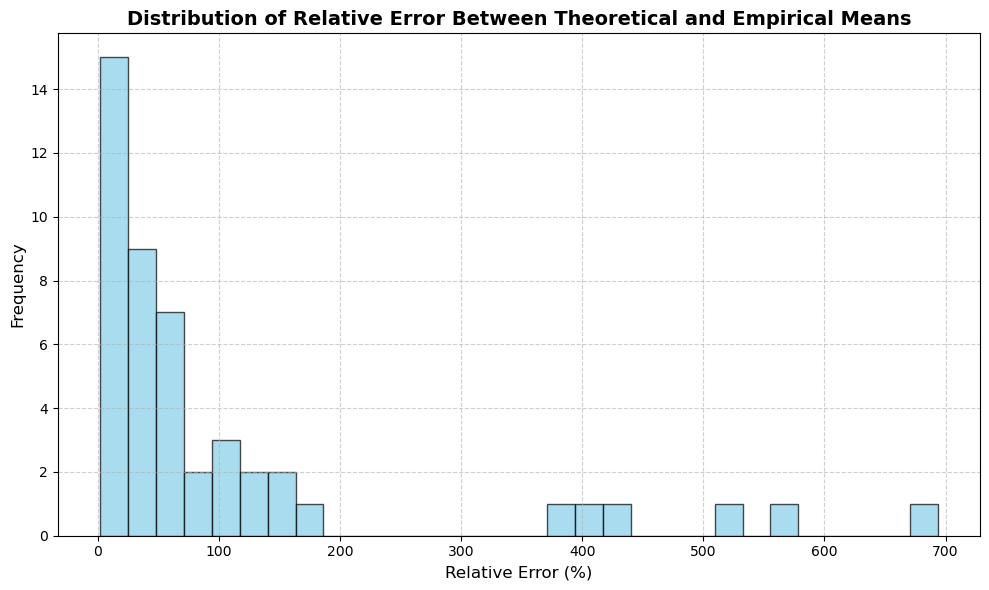

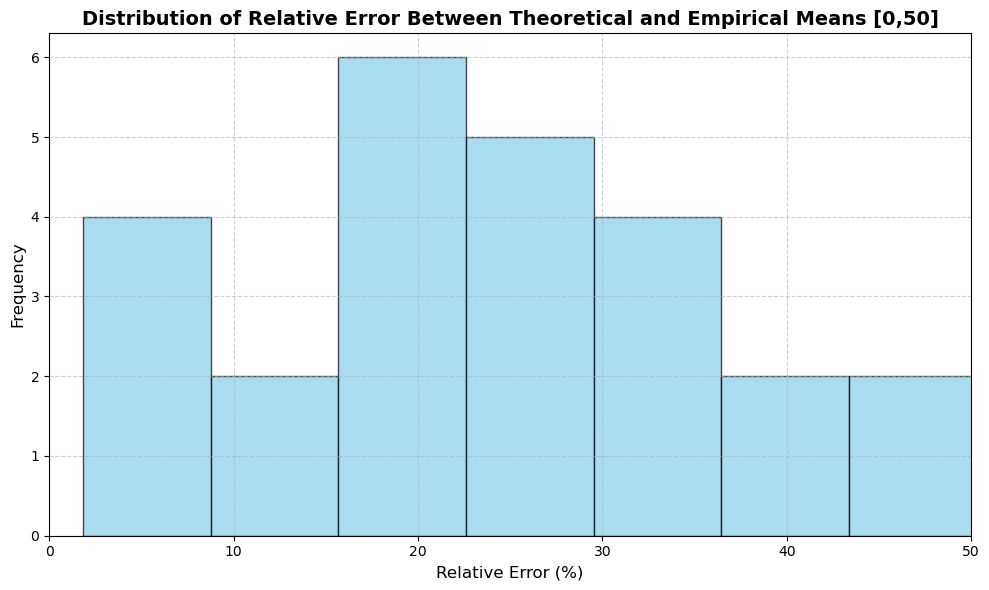

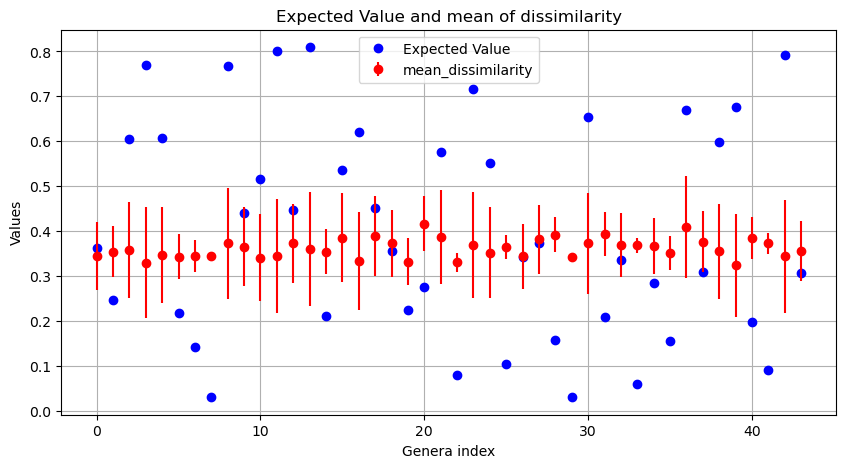

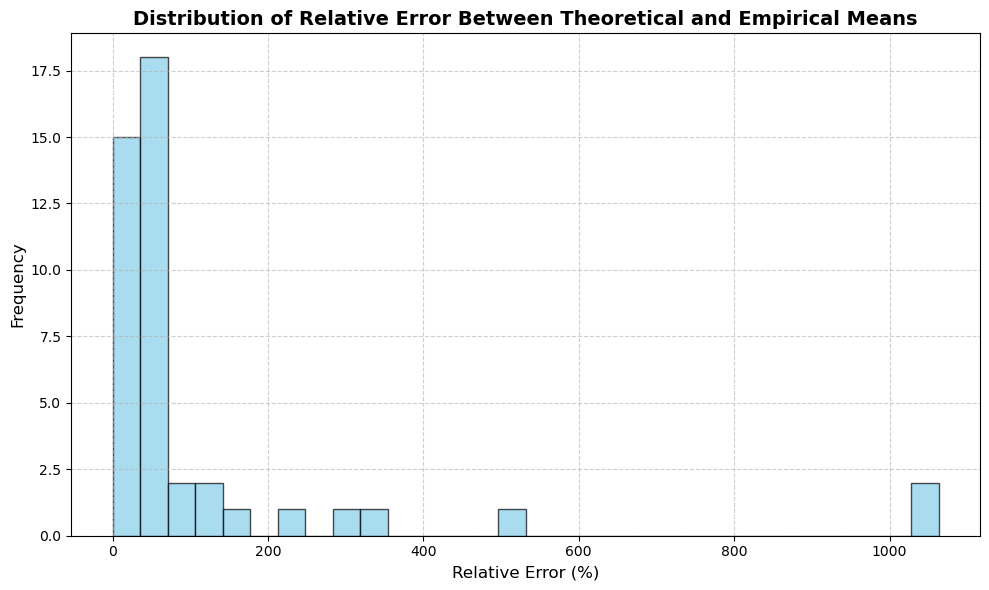

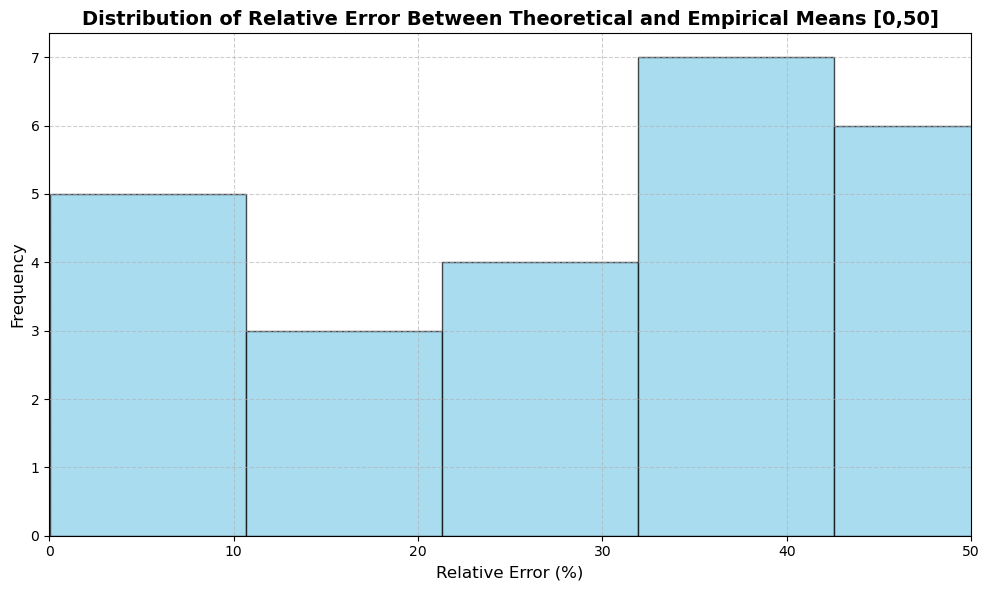

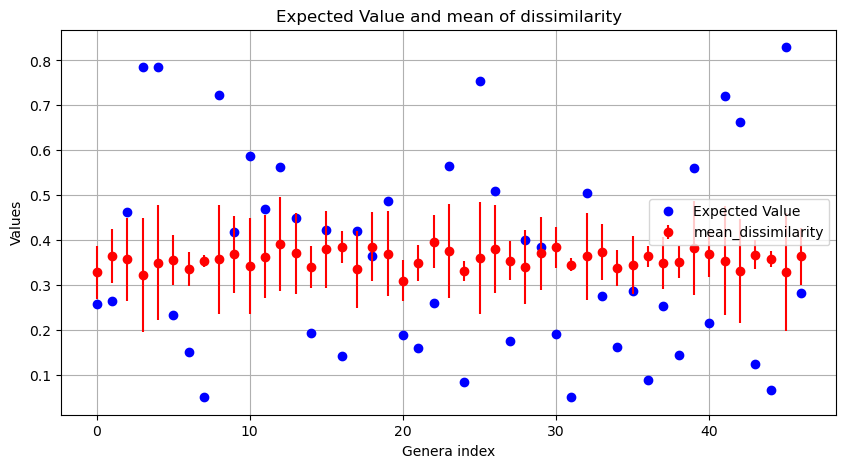

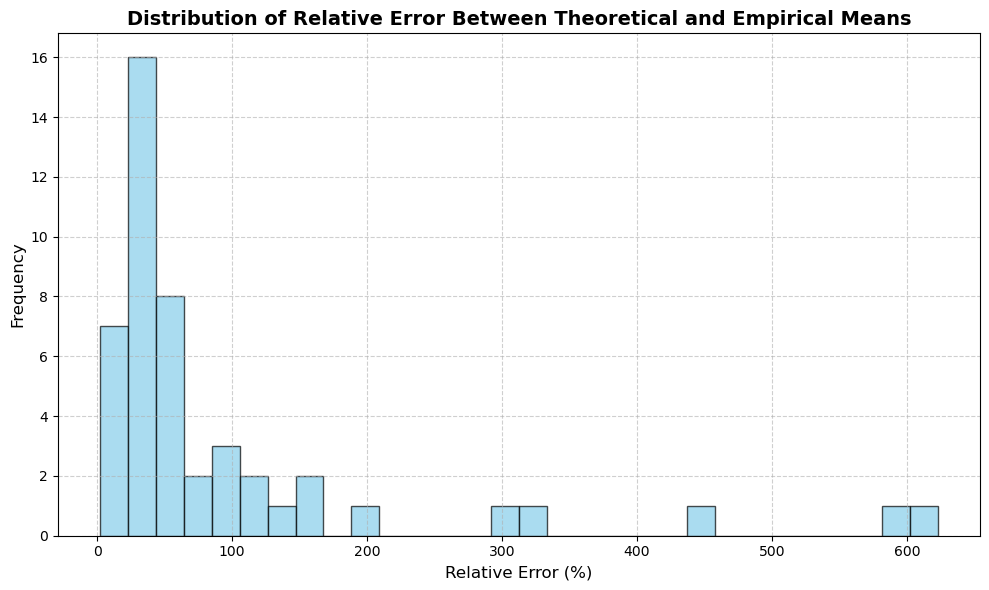

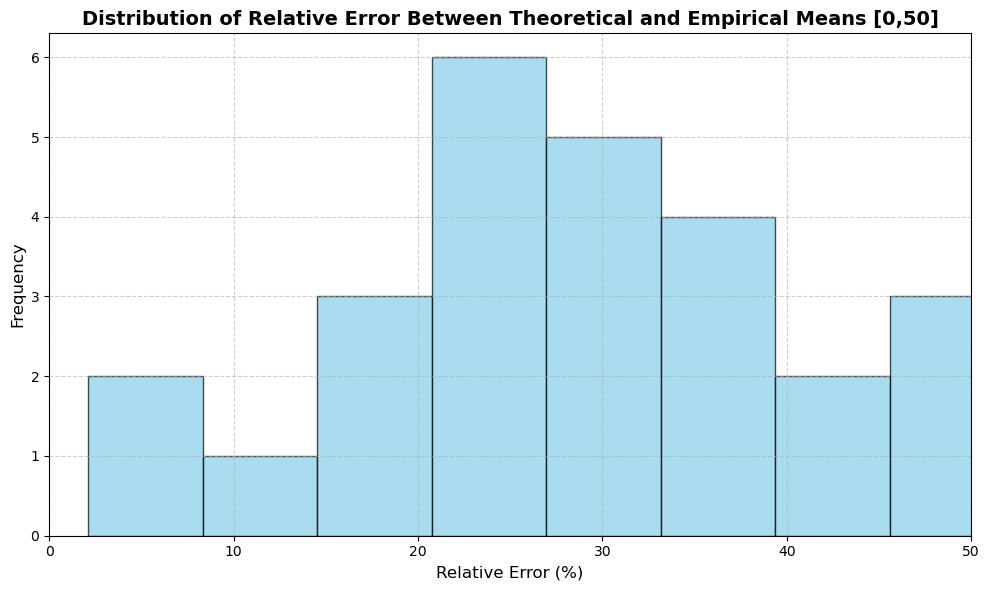

In [ ]:

c=0

for i in range(8):

    absolute_error=[]
    path=f"Data/by_mouse_genus_aggregated/mouse_{i}_genus.csv"
    file=pd.read_csv(path) 
    pdf_arr= []

    mean_diff_arr=[]
    Expected_arr=[]
    relative_err=[]
    err_bar = []
    
    for spec in flat_list[i]:   
        c=c+1
        mean_count=(file["mean"][file["Genus"]==spec]).values
            
        #extract K,sigma, abundances from file
        sigma = sigma_df[f"Mouse {i+1}"][sigma_df["Genus"] == spec].values[0]
        k = K_df[f"Mouse {i+1}"][K_df["Genus"] == spec].values[0]
        abundances = ((file[file["Genus"] == spec].values)[0, 2:])     

        n = np.shape(abundances)[0] - 2
        err_bar.append(sigma / np.sqrt(n))  

        mean_diff_arr.append(mean_non_normalized_diss[i].loc[mean_non_normalized_diss[i][0] == spec, 1].values[0])
        #mean_diff_arr.append(np.mean(abundances))
        expected, relative_error=confrontation(sigma, np.mean(mean_diff_arr))
        
        Expected_arr.append(expected)
        relative_err.append(relative_error)
    
#                                  PLOT
##############################################################################


    ##############################################################################
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(0,len(mean_diff_arr)), Expected_arr,"o", c="b", label="Expected Value")
    plt.errorbar(np.arange(0,len(mean_diff_arr)), mean_diff_arr, yerr = err_bar, fmt = "o",c="r", label="mean_dissimilarity")
    plt.xlabel('Genera index')
    plt.ylabel('Values')
    plt.title('Expected Value and mean of dissimilarity')
    plt.legend()
    plt.grid()
    plt.show()

#                     RELATIVE ERROR HISTOGRAM
##############################################################################

    
    plt.figure(figsize=(10, 6))
    plt.hist(relative_err, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Relative Error (%)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Relative Error Between Theoretical and Empirical Means', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
##############################################################################

    plt.figure(figsize=(10, 6))
    plt.hist(relative_err, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Relative Error (%)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Relative Error Between Theoretical and Empirical Means [0,50]', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0,50)
    plt.tight_layout()
    plt.show()
##############################################################################

As we can see in in Relative Error histogram we can see that a substantial portion of the relative errors falls within the range of 0% to 50%, with the presence of several larger outliers. 
Such high relative errors strongly suggest that the model's predictions consistently deviate from the empirical observations. 

Analyzing the _mean dissimilarity and expected value plot_ we can do a qualitative assessment and see contrast in the behavior of the two components: the dissimilarity mean computed from the data tends to fluctuate closely around a fixed value, instead the theoretical values derived from the model exhibit a broad spread and no consistent pattern. This lack of a clear trend or stability in the theoretical predictions suggests that the underlying assumptions or parameters generating these values may not be robust or adequately grounded in the system's dynamics. 


# **Conclusions**

Given these observations, it can be concluded that the Stochastic Logistic Model is likely not an appropriate or sufficiently robust representation of the complex biological system within the mouse gut. The consistent and substantial relative errors, coupled with the instability of its theoretical predictions, indicate that the model is too simplistic to capture the intricate and multifaceted reality of the system and, in particular, those as complex as the gut microbiome, are characterized by rich and dynamic inter-species interactions. 